In [1]:
import watermarking, utilities, attacks, parameters
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os

# =========================
# Helper Functions
# =========================
def bits_to_watermark_image(bits, watermark_size):
    """Convert extracted bits back to watermark image"""
    # Reshape bits to 2D array
    bits_2d = np.array(bits).reshape(watermark_size, watermark_size)
    
    # Convert 0/1 bits to 0/255 pixel values
    pixels = (bits_2d * 255).astype(np.uint8)
    
    # Create PIL image
    watermark_img = Image.fromarray(pixels, mode='L')  # Grayscale mode
    
    return watermark_img

# =========================
# Configuration
# =========================
HOST_IMAGES_PATH = "dataset/host/"
WATERMARK_PATH = "dataset/watermark_32x32.png"
OUTPUT_PATH = "dataset/analysis/"
NUM_IMAGES = 10

# Create organized output directories
WATERMARKED_DIR = "dataset/watermarked/"
JPEG_Q75_DIR = "dataset/jpeg_q75/"
CROPPED_DIR = "dataset/cropped/"
ROTATION_1DG_DIR = "dataset/rotation_1dg/"
GAUSS_NOISE_DIR = "dataset/gauss_noise/"
UNIFORM_NOISE_DIR = "dataset/uniform_noise/"
WHATSAPP_DIR = "dataset/whatsapp/"

# Create watermark extraction subdirectories
WATERMARKED_WM_DIR = f"{WATERMARKED_DIR}watermark/"
JPEG_Q75_WM_DIR = f"{JPEG_Q75_DIR}watermark/"
CROPPED_WM_DIR = f"{CROPPED_DIR}watermark/"
ROTATION_1DG_WM_DIR = f"{ROTATION_1DG_DIR}watermark/"
GAUSS_NOISE_WM_DIR = f"{GAUSS_NOISE_DIR}watermark/"
UNIFORM_NOISE_WM_DIR = f"{UNIFORM_NOISE_DIR}watermark/"
WHATSAPP_WM_DIR = f"{WHATSAPP_DIR}watermark/"

# Create all directories if they don't exist
for directory in [OUTPUT_PATH, WATERMARKED_DIR, JPEG_Q75_DIR, CROPPED_DIR, 
                  ROTATION_1DG_DIR, GAUSS_NOISE_DIR, UNIFORM_NOISE_DIR, WHATSAPP_DIR,
                  WATERMARKED_WM_DIR, JPEG_Q75_WM_DIR, CROPPED_WM_DIR, 
                  ROTATION_1DG_WM_DIR, GAUSS_NOISE_WM_DIR, UNIFORM_NOISE_WM_DIR, WHATSAPP_WM_DIR]:
    os.makedirs(directory, exist_ok=True)

# =========================
# Analysis Functions
# =========================
def run_single_image_analysis(image_idx):
    """Run complete analysis for a single image"""
    print(f"\n=== Analyzing Image {image_idx} ===")
    
    # Paths for organized storage
    host_path = f"{HOST_IMAGES_PATH}image{image_idx}.jpg"
    watermarked_path = f"{WATERMARKED_DIR}watermarked_{image_idx}.png"
    whatsapp_path =f"{WHATSAPP_DIR}whatsapp_{image_idx}.jpg"
    jpeg_path = f"{JPEG_Q75_DIR}jpeg_q75_{image_idx}.jpg"
    crop_path = f"{CROPPED_DIR}cropped_{image_idx}.png"
    rot_path = f"{ROTATION_1DG_DIR}rotation_1dg_{image_idx}.png"
    gauss_path = f"{GAUSS_NOISE_DIR}gauss_noise_{image_idx}.png"
    uniform_path = f"{UNIFORM_NOISE_DIR}uniform_noise_{image_idx}.png"
    
    # Check if host image exists
    if not os.path.exists(host_path):
        print(f"Host image {host_path} not found!")
        return None
    
    try:
        # 1. Load host image and watermark
        host_pil = Image.open(host_path).convert("RGB")
        watermark_pil = Image.open(WATERMARK_PATH).convert("RGBA")
        
        # Convert host to YCbCr and get Y channel
        Y, Cb, Cr = utilities.to_ycbcr_arrays(host_pil)
        
        # Prepare watermark bits
        wm_bits_true = utilities.prepare_watermark_bits(watermark_pil, parameters.WATERMARK_SIZE)
        
        # Embed watermark
        Y_wm = watermarking.embed_watermark(Y, wm_bits_true)
        
        # Convert back to RGB and save in watermarked directory
        watermarked_pil = utilities.from_ycbcr_arrays(Y_wm, Cb, Cr)
        watermarked_pil.save(watermarked_path)
        
        # Convert to numpy arrays for PSNR calculation
        host_u8 = np.array(host_pil, dtype=np.uint8)
        watermarked_u8 = np.array(watermarked_pil, dtype=np.uint8)
        
        # Calculate PSNR for embedding
        psnr_embed = utilities.psnr(host_u8, watermarked_u8)
        
        # 2. Extract from clean watermarked image (baseline) - BOTH ALGORITHMS
        bits_clean_std = watermarking.extract_watermark(Y_wm, parameters.WATERMARK_SIZE)
        bits_clean_enh = watermarking.extract_watermark_enhanced(Y_wm, parameters.WATERMARK_SIZE)
        
        # Save extracted watermarks as images
        clean_wm_std = bits_to_watermark_image(bits_clean_std, parameters.WATERMARK_SIZE)
        clean_wm_enh = bits_to_watermark_image(bits_clean_enh, parameters.WATERMARK_SIZE)
        clean_wm_std.save(f"{WATERMARKED_WM_DIR}extracted_std_{image_idx}.png")
        clean_wm_enh.save(f"{WATERMARKED_WM_DIR}extracted_enh_{image_idx}.png")
        
        ber_clean_std = utilities.bit_error_rate(wm_bits_true, bits_clean_std)
        ncc_clean_std = utilities.normalized_cross_correlation(wm_bits_true, bits_clean_std)
        
        ber_clean_enh = utilities.bit_error_rate(wm_bits_true, bits_clean_enh)
        ncc_clean_enh = utilities.normalized_cross_correlation(wm_bits_true, bits_clean_enh)
        
        results = {
            'image_id': image_idx,
            'psnr_embed': psnr_embed,
            'clean_ber_std': ber_clean_std,
            'clean_ncc_std': ncc_clean_std,
            'clean_ber_enh': ber_clean_enh,
            'clean_ncc_enh': ncc_clean_enh
        }
        
        # 2b. Extract from whatsapp watermarked image (baseline) - BOTH ALGORITHMS
        whatsapp_pil = Image.open(whatsapp_path).convert("RGB")
        whatsapp_u8 = np.array(whatsapp_pil, dtype=np.uint8)
        psnr_whatsapp = utilities.psnr(watermarked_u8, whatsapp_u8)

        Y_whatsapp, _, _ = utilities.to_ycbcr_arrays(whatsapp_pil)
        bits_whatsapp_std = watermarking.extract_watermark(Y_whatsapp, parameters.WATERMARK_SIZE)
        bits_whatsapp_enh = watermarking.extract_watermark_enhanced(Y_whatsapp, parameters.WATERMARK_SIZE)

        # Save extracted watermarks from WhatsApp images
        whatsapp_wm_std = bits_to_watermark_image(bits_whatsapp_std, parameters.WATERMARK_SIZE)
        whatsapp_wm_enh = bits_to_watermark_image(bits_whatsapp_enh, parameters.WATERMARK_SIZE)
        whatsapp_wm_std.save(f"{WHATSAPP_WM_DIR}extracted_std_{image_idx}.png")
        whatsapp_wm_enh.save(f"{WHATSAPP_WM_DIR}extracted_enh_{image_idx}.png")

        ber_whatsapp_std = utilities.bit_error_rate(wm_bits_true, bits_whatsapp_std)
        ncc_whatsapp_std = utilities.normalized_cross_correlation(wm_bits_true, bits_whatsapp_std)

        ber_whatsapp_enh = utilities.bit_error_rate(wm_bits_true, bits_whatsapp_enh)
        ncc_whatsapp_enh = utilities.normalized_cross_correlation(wm_bits_true, bits_whatsapp_enh)

        results.update({
            'whatsapp_psnr': psnr_whatsapp,
            'whatsapp_ber_std': ber_whatsapp_std,
            'whatsapp_ncc_std': ncc_whatsapp_std,
            'whatsapp_ber_enh': ber_whatsapp_enh,
            'whatsapp_ncc_enh': ncc_whatsapp_enh
        })

        # 3. JPEG Compression Attack (Q=75) - BOTH ALGORITHMS
        attacks.jpeg_attack(watermarked_path, jpeg_path, quality=75)
        
        # Load attacked image and calculate PSNR
        jpeg_pil = Image.open(jpeg_path).convert("RGB")
        jpeg_u8 = np.array(jpeg_pil, dtype=np.uint8)
        psnr_jpeg = utilities.psnr(watermarked_u8, jpeg_u8)
        
        # Extract watermark from JPEG attacked image - BOTH ALGORITHMS
        Y_jpeg, _, _ = utilities.to_ycbcr_arrays(jpeg_pil)
        bits_jpeg_std = watermarking.extract_watermark(Y_jpeg, parameters.WATERMARK_SIZE)
        bits_jpeg_enh = watermarking.extract_watermark_enhanced(Y_jpeg, parameters.WATERMARK_SIZE)
        
        # Save extracted watermarks from JPEG attack
        jpeg_wm_std = bits_to_watermark_image(bits_jpeg_std, parameters.WATERMARK_SIZE)
        jpeg_wm_enh = bits_to_watermark_image(bits_jpeg_enh, parameters.WATERMARK_SIZE)
        jpeg_wm_std.save(f"{JPEG_Q75_WM_DIR}extracted_std_{image_idx}.png")
        jpeg_wm_enh.save(f"{JPEG_Q75_WM_DIR}extracted_enh_{image_idx}.png")
        
        ber_jpeg_std = utilities.bit_error_rate(wm_bits_true, bits_jpeg_std)
        ncc_jpeg_std = utilities.normalized_cross_correlation(wm_bits_true, bits_jpeg_std)
        
        ber_jpeg_enh = utilities.bit_error_rate(wm_bits_true, bits_jpeg_enh)
        ncc_jpeg_enh = utilities.normalized_cross_correlation(wm_bits_true, bits_jpeg_enh)

        results.update({
            'jpeg_psnr': psnr_jpeg,
            'jpeg_ber_std': ber_jpeg_std,
            'jpeg_ncc_std': ncc_jpeg_std,
            'jpeg_ber_enh': ber_jpeg_enh,
            'jpeg_ncc_enh': ncc_jpeg_enh
        })
        
        # 4. Cropping Attack (1 patch, 5% area) - BOTH ALGORITHMS
        crop_u8 = watermarked_u8.copy()
        attacks.crop_attack(crop_u8, area_ratio=0.05, num_patches=1, seed=42)
        crop_pil = Image.fromarray(crop_u8)
        crop_pil.save(crop_path)
        
        # Calculate PSNR for crop attack
        psnr_crop = utilities.psnr(watermarked_u8, crop_u8)
        
        # Extract watermark from cropped image - BOTH ALGORITHMS
        Y_crop, _, _ = utilities.to_ycbcr_arrays(crop_pil)
        bits_crop_std = watermarking.extract_watermark(Y_crop, parameters.WATERMARK_SIZE)
        bits_crop_enh = watermarking.extract_watermark_enhanced(Y_crop, parameters.WATERMARK_SIZE)
        
        # Save extracted watermarks from crop attack
        crop_wm_std = bits_to_watermark_image(bits_crop_std, parameters.WATERMARK_SIZE)
        crop_wm_enh = bits_to_watermark_image(bits_crop_enh, parameters.WATERMARK_SIZE)
        crop_wm_std.save(f"{CROPPED_WM_DIR}extracted_std_{image_idx}.png")
        crop_wm_enh.save(f"{CROPPED_WM_DIR}extracted_enh_{image_idx}.png")
        
        ber_crop_std = utilities.bit_error_rate(wm_bits_true, bits_crop_std)
        ncc_crop_std = utilities.normalized_cross_correlation(wm_bits_true, bits_crop_std)
        
        ber_crop_enh = utilities.bit_error_rate(wm_bits_true, bits_crop_enh)
        ncc_crop_enh = utilities.normalized_cross_correlation(wm_bits_true, bits_crop_enh)

        results.update({
            'crop_psnr': psnr_crop,
            'crop_ber_std': ber_crop_std,
            'crop_ncc_std': ncc_crop_std,
            'crop_ber_enh': ber_crop_enh,
            'crop_ncc_enh': ncc_crop_enh
        })
        
        # 5. Rotation Attack (1 degree) - BOTH ALGORITHMS
        rot_pil = attacks.rotation_attack(watermarked_pil, angle=1.0)
        rot_pil.save(rot_path)
        
        # Load attacked image and calculate PSNR
        rot_u8 = np.array(rot_pil, dtype=np.uint8)
        psnr_rot = utilities.psnr(watermarked_u8, rot_u8)
        
        # Extract watermark - BOTH ALGORITHMS
        Y_rot, _, _ = utilities.to_ycbcr_arrays(rot_pil)
        bits_rot_std = watermarking.extract_watermark(Y_rot, parameters.WATERMARK_SIZE)
        bits_rot_enh = watermarking.extract_watermark_enhanced(Y_rot, parameters.WATERMARK_SIZE)
        
        # Save extracted watermarks from rotation attack
        rot_wm_std = bits_to_watermark_image(bits_rot_std, parameters.WATERMARK_SIZE)
        rot_wm_enh = bits_to_watermark_image(bits_rot_enh, parameters.WATERMARK_SIZE)
        rot_wm_std.save(f"{ROTATION_1DG_WM_DIR}extracted_std_{image_idx}.png")
        rot_wm_enh.save(f"{ROTATION_1DG_WM_DIR}extracted_enh_{image_idx}.png")
        
        ber_rot_std = utilities.bit_error_rate(wm_bits_true, bits_rot_std)
        ncc_rot_std = utilities.normalized_cross_correlation(wm_bits_true, bits_rot_std)
        
        ber_rot_enh = utilities.bit_error_rate(wm_bits_true, bits_rot_enh)
        ncc_rot_enh = utilities.normalized_cross_correlation(wm_bits_true, bits_rot_enh)

        results.update({
            'rot_psnr': psnr_rot,
            'rot_ber_std': ber_rot_std,
            'rot_ncc_std': ncc_rot_std,
            'rot_ber_enh': ber_rot_enh,
            'rot_ncc_enh': ncc_rot_enh
        })
        
        # 6. Gaussian Noise Attack (std=10) - BOTH ALGORITHMS
        gauss_u8 = attacks.gaussian_noise_attack(watermarked_u8.copy(), std=10, seed=42)
        gauss_pil = Image.fromarray(gauss_u8)
        gauss_pil.save(gauss_path)
        
        # Calculate PSNR for Gaussian noise attack
        psnr_gauss = utilities.psnr(watermarked_u8, gauss_u8)
        
        # Extract watermark from Gaussian noise attacked image - BOTH ALGORITHMS
        Y_gauss, _, _ = utilities.to_ycbcr_arrays(gauss_pil)
        bits_gauss_std = watermarking.extract_watermark(Y_gauss, parameters.WATERMARK_SIZE)
        bits_gauss_enh = watermarking.extract_watermark_enhanced(Y_gauss, parameters.WATERMARK_SIZE)
        
        # Save extracted watermarks from Gaussian noise attack
        gauss_wm_std = bits_to_watermark_image(bits_gauss_std, parameters.WATERMARK_SIZE)
        gauss_wm_enh = bits_to_watermark_image(bits_gauss_enh, parameters.WATERMARK_SIZE)
        gauss_wm_std.save(f"{GAUSS_NOISE_WM_DIR}extracted_std_{image_idx}.png")
        gauss_wm_enh.save(f"{GAUSS_NOISE_WM_DIR}extracted_enh_{image_idx}.png")
        
        ber_gauss_std = utilities.bit_error_rate(wm_bits_true, bits_gauss_std)
        ncc_gauss_std = utilities.normalized_cross_correlation(wm_bits_true, bits_gauss_std)
        
        ber_gauss_enh = utilities.bit_error_rate(wm_bits_true, bits_gauss_enh)
        ncc_gauss_enh = utilities.normalized_cross_correlation(wm_bits_true, bits_gauss_enh)

        results.update({
            'gauss_psnr': psnr_gauss,
            'gauss_ber_std': ber_gauss_std,
            'gauss_ncc_std': ncc_gauss_std,
            'gauss_ber_enh': ber_gauss_enh,
            'gauss_ncc_enh': ncc_gauss_enh
        })
        
        # 7. Uniform Noise Attack (intensity=15) - BOTH ALGORITHMS
        uniform_u8 = attacks.uniform_noise_attack(watermarked_u8.copy(), intensity=15, seed=42)
        uniform_pil = Image.fromarray(uniform_u8)
        uniform_pil.save(uniform_path)
        
        # Calculate PSNR for uniform noise attack
        psnr_uniform = utilities.psnr(watermarked_u8, uniform_u8)
        
        # Extract watermark from uniform noise attacked image - BOTH ALGORITHMS
        Y_uniform, _, _ = utilities.to_ycbcr_arrays(uniform_pil)
        bits_uniform_std = watermarking.extract_watermark(Y_uniform, parameters.WATERMARK_SIZE)
        bits_uniform_enh = watermarking.extract_watermark_enhanced(Y_uniform, parameters.WATERMARK_SIZE)

        # Save extracted watermarks from uniform noise attack
        uniform_wm_std = bits_to_watermark_image(bits_uniform_std, parameters.WATERMARK_SIZE)
        uniform_wm_enh = bits_to_watermark_image(bits_uniform_enh, parameters.WATERMARK_SIZE)
        uniform_wm_std.save(f"{UNIFORM_NOISE_WM_DIR}extracted_std_{image_idx}.png")
        uniform_wm_enh.save(f"{UNIFORM_NOISE_WM_DIR}extracted_enh_{image_idx}.png")

        ber_uniform_std = utilities.bit_error_rate(wm_bits_true, bits_uniform_std)
        ncc_uniform_std = utilities.normalized_cross_correlation(wm_bits_true, bits_uniform_std)

        ber_uniform_enh = utilities.bit_error_rate(wm_bits_true, bits_uniform_enh)
        ncc_uniform_enh = utilities.normalized_cross_correlation(wm_bits_true, bits_uniform_enh)

        results.update({
            'uniform_psnr': psnr_uniform,
            'uniform_ber_std': ber_uniform_std,
            'uniform_ncc_std': ncc_uniform_std,
            'uniform_ber_enh': ber_uniform_enh,
            'uniform_ncc_enh': ncc_uniform_enh
        })
        return results
        
    except Exception as e:
        print(f"Error processing image {image_idx}: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

# =========================
# Main Analysis Loop
# =========================
print("Starting Watermarking Analysis...")
print(f"Host images: {HOST_IMAGES_PATH}image1.jpg to image{NUM_IMAGES}.jpg")
print(f"Watermark: {WATERMARK_PATH}")
print(f"Output directories:")
print(f"  - Analysis results: {OUTPUT_PATH}")
print(f"  - Watermarked images: {WATERMARKED_DIR}")
print(f"  - Extracted watermarks: {WATERMARKED_WM_DIR}")
print(f"  - JPEG Q75 attacked: {JPEG_Q75_DIR}")
print(f"  - JPEG Q75 extracted watermarks: {JPEG_Q75_WM_DIR}")
print(f"  - Cropped images: {CROPPED_DIR}")
print(f"  - Cropped extracted watermarks: {CROPPED_WM_DIR}")
print(f"  - Rotation 1° images: {ROTATION_1DG_DIR}")
print(f"  - Rotation 1° extracted watermarks: {ROTATION_1DG_WM_DIR}")
print(f"  - Gaussian noise images: {GAUSS_NOISE_DIR}")
print(f"  - Gaussian noise extracted watermarks: {GAUSS_NOISE_WM_DIR}")
print(f"  - Uniform noise images: {UNIFORM_NOISE_DIR}")
print(f"  - Uniform noise extracted watermarks: {UNIFORM_NOISE_WM_DIR}")
print(f"  - WhatsApp images: {WHATSAPP_DIR}")
print(f"  - WhatsApp extracted watermarks: {WHATSAPP_WM_DIR}")

# Collect results for all images
all_results = []
for i in range(1, NUM_IMAGES + 1):
    result = run_single_image_analysis(i)
    if result is not None:
        all_results.append(result)

Starting Watermarking Analysis...
Host images: dataset/host/image1.jpg to image10.jpg
Watermark: dataset/watermark_32x32.png
Output directories:
  - Analysis results: dataset/analysis/
  - Watermarked images: dataset/watermarked/
  - Extracted watermarks: dataset/watermarked/watermark/
  - JPEG Q75 attacked: dataset/jpeg_q75/
  - JPEG Q75 extracted watermarks: dataset/jpeg_q75/watermark/
  - Cropped images: dataset/cropped/
  - Cropped extracted watermarks: dataset/cropped/watermark/
  - Rotation 1° images: dataset/rotation_1dg/
  - Rotation 1° extracted watermarks: dataset/rotation_1dg/watermark/
  - Gaussian noise images: dataset/gauss_noise/
  - Gaussian noise extracted watermarks: dataset/gauss_noise/watermark/
  - Uniform noise images: dataset/uniform_noise/
  - Uniform noise extracted watermarks: dataset/uniform_noise/watermark/
  - WhatsApp images: dataset/whatsapp/
  - WhatsApp extracted watermarks: dataset/whatsapp/watermark/

=== Analyzing Image 1 ===


C:\Users\Vin Sen\AppData\Local\Temp\ipykernel_38708\3994731653.py:20: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  watermark_img = Image.fromarray(pixels, mode='L')  # Grayscale mode



=== Analyzing Image 2 ===

=== Analyzing Image 3 ===

=== Analyzing Image 3 ===

=== Analyzing Image 4 ===

=== Analyzing Image 4 ===

=== Analyzing Image 5 ===

=== Analyzing Image 5 ===

=== Analyzing Image 6 ===

=== Analyzing Image 6 ===

=== Analyzing Image 7 ===

=== Analyzing Image 7 ===

=== Analyzing Image 8 ===

=== Analyzing Image 8 ===

=== Analyzing Image 9 ===

=== Analyzing Image 9 ===

=== Analyzing Image 10 ===

=== Analyzing Image 10 ===


In [2]:
# =========================
# Results Analysis and Visualization
# =========================
# Convert to DataFrame for easier analysis
df = pd.DataFrame(all_results)

# Save detailed results to CSV
df.to_csv(f"{OUTPUT_PATH}detailed_results.csv", index=False)

# Calculate statistics
stats = {
    'Metric': ['PSNR Embed', 
                'Clean BER Std', 'Clean NCC Std', 'Clean BER Enh', 'Clean NCC Enh',
                'JPEG PSNR', 'JPEG BER Std', 'JPEG NCC Std', 'JPEG BER Enh', 'JPEG NCC Enh',
                'Crop PSNR', 'Crop BER Std', 'Crop NCC Std', 'Crop BER Enh', 'Crop NCC Enh',
                'Rot PSNR', 'Rot BER Std', 'Rot NCC Std', 'Rot BER Enh', 'Rot NCC Enh',
                'Gauss PSNR', 'Gauss BER Std', 'Gauss NCC Std', 'Gauss BER Enh', 'Gauss NCC Enh',
                'Uniform PSNR', 'Uniform BER Std', 'Uniform NCC Std', 'Uniform BER Enh', 'Uniform NCC Enh'],
    'Mean': [
        df['psnr_embed'].mean(),
        df['clean_ber_std'].mean(), df['clean_ncc_std'].mean(), df['clean_ber_enh'].mean(), df['clean_ncc_enh'].mean(),
        df['jpeg_psnr'].mean(), df['jpeg_ber_std'].mean(), df['jpeg_ncc_std'].mean(), df['jpeg_ber_enh'].mean(), df['jpeg_ncc_enh'].mean(),
        df['crop_psnr'].mean(), df['crop_ber_std'].mean(), df['crop_ncc_std'].mean(), df['crop_ber_enh'].mean(), df['crop_ncc_enh'].mean(),
        df['rot_psnr'].mean(), df['rot_ber_std'].mean(), df['rot_ncc_std'].mean(), df['rot_ber_enh'].mean(), df['rot_ncc_enh'].mean(),
        df['gauss_psnr'].mean(), df['gauss_ber_std'].mean(), df['gauss_ncc_std'].mean(), df['gauss_ber_enh'].mean(), df['gauss_ncc_enh'].mean(),
        df['uniform_psnr'].mean(), df['uniform_ber_std'].mean(), df['uniform_ncc_std'].mean(), df['uniform_ber_enh'].mean(), df['uniform_ncc_enh'].mean()
    ],
    'Std': [
        df['psnr_embed'].std(),
        df['clean_ber_std'].std(), df['clean_ncc_std'].std(), df['clean_ber_enh'].std(), df['clean_ncc_enh'].std(),
        df['jpeg_psnr'].std(), df['jpeg_ber_std'].std(), df['jpeg_ncc_std'].std(), df['jpeg_ber_enh'].std(), df['jpeg_ncc_enh'].std(),
        df['crop_psnr'].std(), df['crop_ber_std'].std(), df['crop_ncc_std'].std(), df['crop_ber_enh'].std(), df['crop_ncc_enh'].std(),
        df['rot_psnr'].std(), df['rot_ber_std'].std(), df['rot_ncc_std'].std(), df['rot_ber_enh'].std(), df['rot_ncc_enh'].std(),
        df['gauss_psnr'].std(), df['gauss_ber_std'].std(), df['gauss_ncc_std'].std(), df['gauss_ber_enh'].std(), df['gauss_ncc_enh'].std(),
        df['uniform_psnr'].std(), df['uniform_ber_std'].std(), df['uniform_ncc_std'].std(), df['uniform_ber_enh'].std(), df['uniform_ncc_enh'].std()
    ],
    'Min': [
        df['psnr_embed'].min(),
        df['clean_ber_std'].min(), df['clean_ncc_std'].min(), df['clean_ber_enh'].min(), df['clean_ncc_enh'].min(),
        df['jpeg_psnr'].min(), df['jpeg_ber_std'].min(), df['jpeg_ncc_std'].min(), df['jpeg_ber_enh'].min(), df['jpeg_ncc_enh'].min(),
        df['crop_psnr'].min(), df['crop_ber_std'].min(), df['crop_ncc_std'].min(), df['crop_ber_enh'].min(), df['crop_ncc_enh'].min(),
        df['rot_psnr'].min(), df['rot_ber_std'].min(), df['rot_ncc_std'].min(), df['rot_ber_enh'].min(), df['rot_ncc_enh'].min(),
        df['gauss_psnr'].min(), df['gauss_ber_std'].min(), df['gauss_ncc_std'].min(), df['gauss_ber_enh'].min(), df['gauss_ncc_enh'].min(),
        df['uniform_psnr'].min(), df['uniform_ber_std'].min(), df['uniform_ncc_std'].min(), df['uniform_ber_enh'].min(), df['uniform_ncc_enh'].min()
    ],
    'Max': [
        df['psnr_embed'].max(),
        df['clean_ber_std'].max(), df['clean_ncc_std'].max(), df['clean_ber_enh'].max(), df['clean_ncc_enh'].max(),
        df['jpeg_psnr'].max(), df['jpeg_ber_std'].max(), df['jpeg_ncc_std'].max(), df['jpeg_ber_enh'].max(), df['jpeg_ncc_enh'].max(),
        df['crop_psnr'].max(), df['crop_ber_std'].max(), df['crop_ncc_std'].max(), df['crop_ber_enh'].max(), df['crop_ncc_enh'].max(),
        df['rot_psnr'].max(), df['rot_ber_std'].max(), df['rot_ncc_std'].max(), df['rot_ber_enh'].max(), df['rot_ncc_enh'].max(),
        df['gauss_psnr'].max(), df['gauss_ber_std'].max(), df['gauss_ncc_std'].max(), df['gauss_ber_enh'].max(), df['gauss_ncc_enh'].max(),
        df['uniform_psnr'].max(), df['uniform_ber_std'].max(), df['uniform_ncc_std'].max(), df['uniform_ber_enh'].max(), df['uniform_ncc_enh'].max()
    ]
}

stats_df = pd.DataFrame(stats)
stats_df.to_csv(f"{OUTPUT_PATH}summary_statistics.csv", index=False)

# Print summary statistics
print("\n" + "="*60)
print("WATERMARKING ANALYSIS SUMMARY")
print("="*60)
print(f"Number of successfully processed images: {len(all_results)}")
print(f"\nEmbedding Quality (PSNR): {df['psnr_embed'].mean():.2f} ± {df['psnr_embed'].std():.2f} dB")
print(f"Clean Extraction BER (Std): {df['clean_ber_std'].mean():.4f} ± {df['clean_ber_std'].std():.4f}")
print(f"Clean Extraction NCC (Std): {df['clean_ncc_std'].mean():.4f} ± {df['clean_ncc_std'].std():.4f}")
print(f"Clean Extraction BER (Enh): {df['clean_ber_enh'].mean():.4f} ± {df['clean_ber_enh'].std():.4f}")
print(f"Clean Extraction NCC (Enh): {df['clean_ncc_enh'].mean():.4f} ± {df['clean_ncc_enh'].std():.4f}")

print(f"\nJPEG Q75 Attack:")
print(f"  PSNR: {df['jpeg_psnr'].mean():.2f} ± {df['jpeg_psnr'].std():.2f} dB")
print(f"  BER (Std):  {df['jpeg_ber_std'].mean():.4f} ± {df['jpeg_ber_std'].std():.4f}")
print(f"  NCC (Std):  {df['jpeg_ncc_std'].mean():.4f} ± {df['jpeg_ncc_std'].std():.4f}")
print(f"  BER (Enh):  {df['jpeg_ber_enh'].mean():.4f} ± {df['jpeg_ber_enh'].std():.4f}")
print(f"  NCC (Enh):  {df['jpeg_ncc_enh'].mean():.4f} ± {df['jpeg_ncc_enh'].std():.4f}")

print(f"\nCropping Attack (5% area):")
print(f"  PSNR: {df['crop_psnr'].mean():.2f} ± {df['crop_psnr'].std():.2f} dB")
print(f"  BER (Std):  {df['crop_ber_std'].mean():.4f} ± {df['crop_ber_std'].std():.4f}")
print(f"  NCC (Std):  {df['crop_ncc_std'].mean():.4f} ± {df['crop_ncc_std'].std():.4f}")
print(f"  BER (Enh):  {df['crop_ber_enh'].mean():.4f} ± {df['crop_ber_enh'].std():.4f}")
print(f"  NCC (Enh):  {df['crop_ncc_enh'].mean():.4f} ± {df['crop_ncc_enh'].std():.4f}")

print(f"\nRotation Attack (1°):")
print(f"  PSNR: {df['rot_psnr'].mean():.2f} ± {df['rot_psnr'].std():.2f} dB")
print(f"  BER (Std):  {df['rot_ber_std'].mean():.4f} ± {df['rot_ber_std'].std():.4f}")
print(f"  NCC (Std):  {df['rot_ncc_std'].mean():.4f} ± {df['rot_ncc_std'].std():.4f}")
print(f"  BER (Enh):  {df['rot_ber_enh'].mean():.4f} ± {df['rot_ber_enh'].std():.4f}")
print(f"  NCC (Enh):  {df['rot_ncc_enh'].mean():.4f} ± {df['rot_ncc_enh'].std():.4f}")

print(f"\nGaussian Noise Attack (σ=10):")
print(f"  PSNR: {df['gauss_psnr'].mean():.2f} ± {df['gauss_psnr'].std():.2f} dB")
print(f"  BER (Std):  {df['gauss_ber_std'].mean():.4f} ± {df['gauss_ber_std'].std():.4f}")
print(f"  NCC (Std):  {df['gauss_ncc_std'].mean():.4f} ± {df['gauss_ncc_std'].std():.4f}")
print(f"  BER (Enh):  {df['gauss_ber_enh'].mean():.4f} ± {df['gauss_ber_enh'].std():.4f}")
print(f"  NCC (Enh):  {df['gauss_ncc_enh'].mean():.4f} ± {df['gauss_ncc_enh'].std():.4f}")

print(f"\nUniform Noise Attack (±15):")
print(f"  PSNR: {df['uniform_psnr'].mean():.2f} ± {df['uniform_psnr'].std():.2f} dB")
print(f"  BER (Std):  {df['uniform_ber_std'].mean():.4f} ± {df['uniform_ber_std'].std():.4f}")
print(f"  NCC (Std):  {df['uniform_ncc_std'].mean():.4f} ± {df['uniform_ncc_std'].std():.4f}")
print(f"  BER (Enh):  {df['uniform_ber_enh'].mean():.4f} ± {df['uniform_ber_enh'].std():.4f}")
print(f"  NCC (Enh):  {df['uniform_ncc_enh'].mean():.4f} ± {df['uniform_ncc_enh'].std():.4f}")


WATERMARKING ANALYSIS SUMMARY
Number of successfully processed images: 10

Embedding Quality (PSNR): 33.12 ± 0.72 dB
Clean Extraction BER (Std): 0.0000 ± 0.0000
Clean Extraction NCC (Std): 1.0000 ± 0.0000
Clean Extraction BER (Enh): 0.0000 ± 0.0000
Clean Extraction NCC (Enh): 1.0000 ± 0.0000

JPEG Q75 Attack:
  PSNR: 38.97 ± 0.86 dB
  BER (Std):  0.0007 ± 0.0009
  NCC (Std):  0.9996 ± 0.0005
  BER (Enh):  0.0007 ± 0.0009
  NCC (Enh):  0.9996 ± 0.0005

Cropping Attack (5% area):
  PSNR: 19.21 ± 2.63 dB
  BER (Std):  0.0380 ± 0.0120
  NCC (Std):  0.9788 ± 0.0068
  BER (Enh):  0.0380 ± 0.0120
  NCC (Enh):  0.9788 ± 0.0068

Rotation Attack (1°):
  PSNR: 19.71 ± 2.65 dB
  BER (Std):  0.5557 ± 0.0394
  NCC (Std):  0.6206 ± 0.0358
  BER (Enh):  0.0913 ± 0.0615
  NCC (Enh):  0.9476 ± 0.0361

Gaussian Noise Attack (σ=10):
  PSNR: 28.30 ± 0.11 dB
  BER (Std):  0.0011 ± 0.0010
  NCC (Std):  0.9994 ± 0.0005
  BER (Enh):  0.0011 ± 0.0010
  NCC (Enh):  0.9994 ± 0.0005

Uniform Noise Attack (±15):
 

In [22]:
# 1. Show only PSNR columns
psnr_cols = ['image_id', 'psnr_embed', 'jpeg_psnr', 'crop_psnr', 'rot_psnr', 'gauss_psnr', 'uniform_psnr']
df[psnr_cols]

,image_id,psnr_embed,jpeg_psnr,crop_psnr,rot_psnr,gauss_psnr,uniform_psnr
0,1,34.340170,39.195396,17.295372,18.433921,28.127631,29.383453
1,2,32.765549,39.969343,19.259892,17.630269,28.469691,29.603761
2,3,34.185261,38.854382,19.657245,19.756309,28.241246,29.484759
3,4,32.722399,38.383412,23.038575,24.576749,28.353734,29.579303
4,5,32.156277,40.003856,19.058459,21.882425,28.139595,29.385212
5,6,32.594341,38.397369,22.529882,23.111846,28.326868,29.555962
6,7,33.257504,38.168702,14.683619,17.871949,28.350478,29.589945
7,8,33.475877,37.493086,21.055015,17.371796,28.323876,29.535821
8,9,32.461083,39.926431,16.238862,16.806705,28.260460,29.496944
9,10,33.224431,39.325928,19.246997,19.610179,28.394580,29.534391


In [23]:
# 2. Show only Standard Algorithm BER columns
ber_std_cols = ['image_id', 'clean_ber_std', 'jpeg_ber_std', 'crop_ber_std', 'rot_ber_std', 'gauss_ber_std', 'uniform_ber_std']
df[ber_std_cols]

,image_id,clean_ber_std,jpeg_ber_std,crop_ber_std,rot_ber_std,gauss_ber_std,uniform_ber_std
0,1,0.0,0.000977,0.043945,0.514648,0.002930,0.001953
1,2,0.0,0.000000,0.052734,0.596680,0.000977,0.001953
2,3,0.0,0.000000,0.033203,0.561523,0.000000,0.000000
3,4,0.0,0.000000,0.020508,0.581055,0.001953,0.001953
4,5,0.0,0.002930,0.043945,0.519531,0.000977,0.000000
5,6,0.0,0.000977,0.019531,0.550781,0.000977,0.000000
6,7,0.0,0.000000,0.053711,0.631836,0.000977,0.000000
7,8,0.0,0.000977,0.030273,0.518555,0.001953,0.001953
8,9,0.0,0.000977,0.043945,0.518555,0.000000,0.000000
9,10,0.0,0.000000,0.038086,0.563477,0.000000,0.000000


In [24]:
# 3. Show only Enhanced Algorithm BER columns
ber_enh_cols = ['image_id', 'clean_ber_enh', 'jpeg_ber_enh', 'crop_ber_enh', 'rot_ber_enh', 'gauss_ber_enh', 'uniform_ber_enh']
df[ber_enh_cols]

,image_id,clean_ber_enh,jpeg_ber_enh,crop_ber_enh,rot_ber_enh,gauss_ber_enh,uniform_ber_enh
0,1,0.0,0.000977,0.043945,0.006836,0.002930,0.001953
1,2,0.0,0.000000,0.052734,0.129883,0.000977,0.001953
2,3,0.0,0.000000,0.033203,0.077148,0.000000,0.000000
3,4,0.0,0.000000,0.020508,0.125977,0.001953,0.001953
4,5,0.0,0.002930,0.043945,0.103516,0.000977,0.000000
5,6,0.0,0.000977,0.019531,0.203125,0.000977,0.000000
6,7,0.0,0.000000,0.053711,0.032227,0.000977,0.000000
7,8,0.0,0.000977,0.030273,0.034180,0.001953,0.001953
8,9,0.0,0.000977,0.043945,0.147461,0.000000,0.000000
9,10,0.0,0.000000,0.038086,0.052734,0.000000,0.000000


In [25]:
# 4. Show only Standard Algorithm NCC columns
ncc_std_cols = ['image_id', 'clean_ncc_std', 'jpeg_ncc_std', 'crop_ncc_std', 'rot_ncc_std', 'gauss_ncc_std', 'uniform_ncc_std']
df[ncc_std_cols]

,image_id,clean_ncc_std,jpeg_ncc_std,crop_ncc_std,rot_ncc_std,gauss_ncc_std,uniform_ncc_std
0,1,1.0,0.999461,0.975426,0.657632,0.998386,0.998923
1,2,1.0,1.000000,0.970437,0.583955,0.999460,0.998921
2,3,1.0,1.000000,0.981490,0.616300,1.000000,1.000000
3,4,1.0,1.000000,0.988608,0.598476,0.998923,0.998923
4,5,1.0,0.998381,0.975426,0.652841,0.999461,1.000000
5,6,1.0,0.999460,0.989154,0.625778,0.999461,1.000000
6,7,1.0,1.000000,0.969881,0.549621,0.999461,1.000000
7,8,1.0,0.999461,0.983137,0.653755,0.998923,0.998923
8,9,1.0,0.999460,0.975426,0.653626,1.000000,1.000000
9,10,1.0,1.000000,0.978738,0.614500,1.000000,1.000000


In [26]:
# 5. Show only Enhanced Algorithm NCC columns
ncc_enh_cols = ['image_id', 'clean_ncc_enh', 'jpeg_ncc_enh', 'crop_ncc_enh', 'rot_ncc_enh', 'gauss_ncc_enh', 'uniform_ncc_enh']
df[ncc_enh_cols]

,image_id,clean_ncc_enh,jpeg_ncc_enh,crop_ncc_enh,rot_ncc_enh,gauss_ncc_enh,uniform_ncc_enh
0,1,1.0,0.999461,0.975426,0.996218,0.998386,0.998923
1,2,1.0,1.000000,0.970437,0.925487,0.999460,0.998921
2,3,1.0,1.000000,0.981490,0.956441,1.000000,1.000000
3,4,1.0,1.000000,0.988608,0.927818,0.998923,0.998923
4,5,1.0,0.998381,0.975426,0.941091,0.999461,1.000000
5,6,1.0,0.999460,0.989154,0.880696,0.999461,1.000000
6,7,1.0,1.000000,0.969881,0.982040,0.999461,1.000000
7,8,1.0,0.999461,0.983137,0.980940,0.998923,0.998923
8,9,1.0,0.999460,0.975426,0.914937,1.000000,1.000000
9,10,1.0,1.000000,0.978738,0.970437,1.000000,1.000000


In [27]:
# 6. Show only Clean extraction results (both algorithms)
clean_cols = ['image_id', 'clean_ber_std', 'clean_ncc_std', 'clean_ber_enh', 'clean_ncc_enh']
df[clean_cols]

,image_id,clean_ber_std,clean_ncc_std,clean_ber_enh,clean_ncc_enh
0,1,0.0,1.0,0.0,1.0
1,2,0.0,1.0,0.0,1.0
2,3,0.0,1.0,0.0,1.0
3,4,0.0,1.0,0.0,1.0
4,5,0.0,1.0,0.0,1.0
5,6,0.0,1.0,0.0,1.0
6,7,0.0,1.0,0.0,1.0
7,8,0.0,1.0,0.0,1.0
8,9,0.0,1.0,0.0,1.0
9,10,0.0,1.0,0.0,1.0


In [30]:
# 7. Show only JPEG attack results
jpeg_cols = ['image_id', 'jpeg_psnr', 'jpeg_ber_std', 'jpeg_ncc_std', 'jpeg_ber_enh', 'jpeg_ncc_enh']
df[jpeg_cols]

,image_id,jpeg_psnr,jpeg_ber_std,jpeg_ncc_std,jpeg_ber_enh,jpeg_ncc_enh
0,1,39.195396,0.000977,0.999461,0.000977,0.999461
1,2,39.969343,0.000000,1.000000,0.000000,1.000000
2,3,38.854382,0.000000,1.000000,0.000000,1.000000
3,4,38.383412,0.000000,1.000000,0.000000,1.000000
4,5,40.003856,0.002930,0.998381,0.002930,0.998381
5,6,38.397369,0.000977,0.999460,0.000977,0.999460
6,7,38.168702,0.000000,1.000000,0.000000,1.000000
7,8,37.493086,0.000977,0.999461,0.000977,0.999461
8,9,39.926431,0.000977,0.999460,0.000977,0.999460
9,10,39.325928,0.000000,1.000000,0.000000,1.000000


In [31]:
# 8. Show only WhatsApp attack results
whatsapp_cols = ['image_id', 'whatsapp_psnr', 'whatsapp_ber_std', 'whatsapp_ncc_std', 'whatsapp_ber_enh', 'whatsapp_ncc_enh']
df[whatsapp_cols]

,image_id,whatsapp_psnr,whatsapp_ber_std,whatsapp_ncc_std,whatsapp_ber_enh,whatsapp_ncc_enh
0,1,43.871484,0.000000,1.000000,0.000000,1.000000
1,2,44.513554,0.000000,1.000000,0.000000,1.000000
2,3,43.550166,0.000000,1.000000,0.000000,1.000000
3,4,43.267612,0.000000,1.000000,0.000000,1.000000
4,5,45.029009,0.000000,1.000000,0.000000,1.000000
5,6,43.019232,0.000000,1.000000,0.000000,1.000000
6,7,41.628318,0.000000,1.000000,0.000000,1.000000
7,8,41.518173,0.000977,0.999461,0.000977,0.999461
8,9,44.416083,0.000000,1.000000,0.000000,1.000000
9,10,43.681105,0.000000,1.000000,0.000000,1.000000


In [32]:
# 9. Show only Cropping attack results
crop_cols = ['image_id', 'crop_psnr', 'crop_ber_std', 'crop_ncc_std', 'crop_ber_enh', 'crop_ncc_enh']
df[crop_cols]

,image_id,crop_psnr,crop_ber_std,crop_ncc_std,crop_ber_enh,crop_ncc_enh
0,1,17.295372,0.043945,0.975426,0.043945,0.975426
1,2,19.259892,0.052734,0.970437,0.052734,0.970437
2,3,19.657245,0.033203,0.981490,0.033203,0.981490
3,4,23.038575,0.020508,0.988608,0.020508,0.988608
4,5,19.058459,0.043945,0.975426,0.043945,0.975426
5,6,22.529882,0.019531,0.989154,0.019531,0.989154
6,7,14.683619,0.053711,0.969881,0.053711,0.969881
7,8,21.055015,0.030273,0.983137,0.030273,0.983137
8,9,16.238862,0.043945,0.975426,0.043945,0.975426
9,10,19.246997,0.038086,0.978738,0.038086,0.978738


In [33]:
# 10. Show only Rotation attack results
rotation_cols = ['image_id', 'rot_psnr', 'rot_ber_std', 'rot_ncc_std', 'rot_ber_enh', 'rot_ncc_enh']
df[rotation_cols]

,image_id,rot_psnr,rot_ber_std,rot_ncc_std,rot_ber_enh,rot_ncc_enh
0,1,18.433921,0.514648,0.657632,0.006836,0.996218
1,2,17.630269,0.596680,0.583955,0.129883,0.925487
2,3,19.756309,0.561523,0.616300,0.077148,0.956441
3,4,24.576749,0.581055,0.598476,0.125977,0.927818
4,5,21.882425,0.519531,0.652841,0.103516,0.941091
5,6,23.111846,0.550781,0.625778,0.203125,0.880696
6,7,17.871949,0.631836,0.549621,0.032227,0.982040
7,8,17.371796,0.518555,0.653755,0.034180,0.980940
8,9,16.806705,0.518555,0.653626,0.147461,0.914937
9,10,19.610179,0.563477,0.614500,0.052734,0.970437


In [34]:
# 11. Show only Gaussian Noise attack results
gauss_cols = ['image_id', 'gauss_psnr', 'gauss_ber_std', 'gauss_ncc_std', 'gauss_ber_enh', 'gauss_ncc_enh']
df[gauss_cols]

,image_id,gauss_psnr,gauss_ber_std,gauss_ncc_std,gauss_ber_enh,gauss_ncc_enh
0,1,28.127631,0.002930,0.998386,0.002930,0.998386
1,2,28.469691,0.000977,0.999460,0.000977,0.999460
2,3,28.241246,0.000000,1.000000,0.000000,1.000000
3,4,28.353734,0.001953,0.998923,0.001953,0.998923
4,5,28.139595,0.000977,0.999461,0.000977,0.999461
5,6,28.326868,0.000977,0.999461,0.000977,0.999461
6,7,28.350478,0.000977,0.999461,0.000977,0.999461
7,8,28.323876,0.001953,0.998923,0.001953,0.998923
8,9,28.260460,0.000000,1.000000,0.000000,1.000000
9,10,28.394580,0.000000,1.000000,0.000000,1.000000


In [35]:
# 12. Show only Uniform Noise attack results
uniform_cols = ['image_id', 'uniform_psnr', 'uniform_ber_std', 'uniform_ncc_std', 'uniform_ber_enh', 'uniform_ncc_enh']
df[uniform_cols]

,image_id,uniform_psnr,uniform_ber_std,uniform_ncc_std,uniform_ber_enh,uniform_ncc_enh
0,1,29.383453,0.001953,0.998923,0.001953,0.998923
1,2,29.603761,0.001953,0.998921,0.001953,0.998921
2,3,29.484759,0.000000,1.000000,0.000000,1.000000
3,4,29.579303,0.001953,0.998923,0.001953,0.998923
4,5,29.385212,0.000000,1.000000,0.000000,1.000000
5,6,29.555962,0.000000,1.000000,0.000000,1.000000
6,7,29.589945,0.000000,1.000000,0.000000,1.000000
7,8,29.535821,0.001953,0.998923,0.001953,0.998923
8,9,29.496944,0.000000,1.000000,0.000000,1.000000
9,10,29.534391,0.000000,1.000000,0.000000,1.000000


In [36]:
# 13. Show ALL PSNR columns (including WhatsApp)
all_psnr_cols = ['image_id', 'psnr_embed', 'whatsapp_psnr', 'jpeg_psnr', 'crop_psnr', 'rot_psnr', 'gauss_psnr', 'uniform_psnr']
df[all_psnr_cols]

,image_id,psnr_embed,whatsapp_psnr,jpeg_psnr,crop_psnr,rot_psnr,gauss_psnr,uniform_psnr
0,1,34.340170,43.871484,39.195396,17.295372,18.433921,28.127631,29.383453
1,2,32.765549,44.513554,39.969343,19.259892,17.630269,28.469691,29.603761
2,3,34.185261,43.550166,38.854382,19.657245,19.756309,28.241246,29.484759
3,4,32.722399,43.267612,38.383412,23.038575,24.576749,28.353734,29.579303
4,5,32.156277,45.029009,40.003856,19.058459,21.882425,28.139595,29.385212
5,6,32.594341,43.019232,38.397369,22.529882,23.111846,28.326868,29.555962
6,7,33.257504,41.628318,38.168702,14.683619,17.871949,28.350478,29.589945
7,8,33.475877,41.518173,37.493086,21.055015,17.371796,28.323876,29.535821
8,9,32.461083,44.416083,39.926431,16.238862,16.806705,28.260460,29.496944
9,10,33.224431,43.681105,39.325928,19.246997,19.610179,28.394580,29.534391


In [37]:
# 14. Show comparison between Standard and Enhanced algorithms for all attacks
comparison_cols = ['image_id', 
                   'clean_ber_std', 'clean_ber_enh', 'clean_ncc_std', 'clean_ncc_enh',
                   'whatsapp_ber_std', 'whatsapp_ber_enh', 'whatsapp_ncc_std', 'whatsapp_ncc_enh',
                   'jpeg_ber_std', 'jpeg_ber_enh', 'jpeg_ncc_std', 'jpeg_ncc_enh']
df[comparison_cols]

,image_id,clean_ber_std,clean_ber_enh,clean_ncc_std,clean_ncc_enh,whatsapp_ber_std,whatsapp_ber_enh,whatsapp_ncc_std,whatsapp_ncc_enh,jpeg_ber_std,jpeg_ber_enh,jpeg_ncc_std,jpeg_ncc_enh
0,1,0.0,0.0,1.0,1.0,0.000000,0.000000,1.000000,1.000000,0.000977,0.000977,0.999461,0.999461
1,2,0.0,0.0,1.0,1.0,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
2,3,0.0,0.0,1.0,1.0,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
3,4,0.0,0.0,1.0,1.0,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
4,5,0.0,0.0,1.0,1.0,0.000000,0.000000,1.000000,1.000000,0.002930,0.002930,0.998381,0.998381
5,6,0.0,0.0,1.0,1.0,0.000000,0.000000,1.000000,1.000000,0.000977,0.000977,0.999460,0.999460
6,7,0.0,0.0,1.0,1.0,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
7,8,0.0,0.0,1.0,1.0,0.000977,0.000977,0.999461,0.999461,0.000977,0.000977,0.999461,0.999461
8,9,0.0,0.0,1.0,1.0,0.000000,0.000000,1.000000,1.000000,0.000977,0.000977,0.999460,0.999460
9,10,0.0,0.0,1.0,1.0,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000


In [38]:
# 15. Show noise attacks comparison (Gaussian vs Uniform)
noise_cols = ['image_id', 
              'gauss_psnr', 'gauss_ber_std', 'gauss_ncc_std', 'gauss_ber_enh', 'gauss_ncc_enh',
              'uniform_psnr', 'uniform_ber_std', 'uniform_ncc_std', 'uniform_ber_enh', 'uniform_ncc_enh']
df[noise_cols]

,image_id,gauss_psnr,gauss_ber_std,gauss_ncc_std,gauss_ber_enh,gauss_ncc_enh,uniform_psnr,uniform_ber_std,uniform_ncc_std,uniform_ber_enh,uniform_ncc_enh
0,1,28.127631,0.002930,0.998386,0.002930,0.998386,29.383453,0.001953,0.998923,0.001953,0.998923
1,2,28.469691,0.000977,0.999460,0.000977,0.999460,29.603761,0.001953,0.998921,0.001953,0.998921
2,3,28.241246,0.000000,1.000000,0.000000,1.000000,29.484759,0.000000,1.000000,0.000000,1.000000
3,4,28.353734,0.001953,0.998923,0.001953,0.998923,29.579303,0.001953,0.998923,0.001953,0.998923
4,5,28.139595,0.000977,0.999461,0.000977,0.999461,29.385212,0.000000,1.000000,0.000000,1.000000
5,6,28.326868,0.000977,0.999461,0.000977,0.999461,29.555962,0.000000,1.000000,0.000000,1.000000
6,7,28.350478,0.000977,0.999461,0.000977,0.999461,29.589945,0.000000,1.000000,0.000000,1.000000
7,8,28.323876,0.001953,0.998923,0.001953,0.998923,29.535821,0.001953,0.998923,0.001953,0.998923
8,9,28.260460,0.000000,1.000000,0.000000,1.000000,29.496944,0.000000,1.000000,0.000000,1.000000
9,10,28.394580,0.000000,1.000000,0.000000,1.000000,29.534391,0.000000,1.000000,0.000000,1.000000


In [39]:
# 16. Show geometric attacks comparison (Crop vs Rotation)
geometric_cols = ['image_id',
                  'crop_psnr', 'crop_ber_std', 'crop_ncc_std', 'crop_ber_enh', 'crop_ncc_enh',
                  'rot_psnr', 'rot_ber_std', 'rot_ncc_std', 'rot_ber_enh', 'rot_ncc_enh']
df[geometric_cols]

,image_id,crop_psnr,crop_ber_std,crop_ncc_std,crop_ber_enh,crop_ncc_enh,rot_psnr,rot_ber_std,rot_ncc_std,rot_ber_enh,rot_ncc_enh
0,1,17.295372,0.043945,0.975426,0.043945,0.975426,18.433921,0.514648,0.657632,0.006836,0.996218
1,2,19.259892,0.052734,0.970437,0.052734,0.970437,17.630269,0.596680,0.583955,0.129883,0.925487
2,3,19.657245,0.033203,0.981490,0.033203,0.981490,19.756309,0.561523,0.616300,0.077148,0.956441
3,4,23.038575,0.020508,0.988608,0.020508,0.988608,24.576749,0.581055,0.598476,0.125977,0.927818
4,5,19.058459,0.043945,0.975426,0.043945,0.975426,21.882425,0.519531,0.652841,0.103516,0.941091
5,6,22.529882,0.019531,0.989154,0.019531,0.989154,23.111846,0.550781,0.625778,0.203125,0.880696
6,7,14.683619,0.053711,0.969881,0.053711,0.969881,17.871949,0.631836,0.549621,0.032227,0.982040
7,8,21.055015,0.030273,0.983137,0.030273,0.983137,17.371796,0.518555,0.653755,0.034180,0.980940
8,9,16.238862,0.043945,0.975426,0.043945,0.975426,16.806705,0.518555,0.653626,0.147461,0.914937
9,10,19.246997,0.038086,0.978738,0.038086,0.978738,19.610179,0.563477,0.614500,0.052734,0.970437


# PSNR

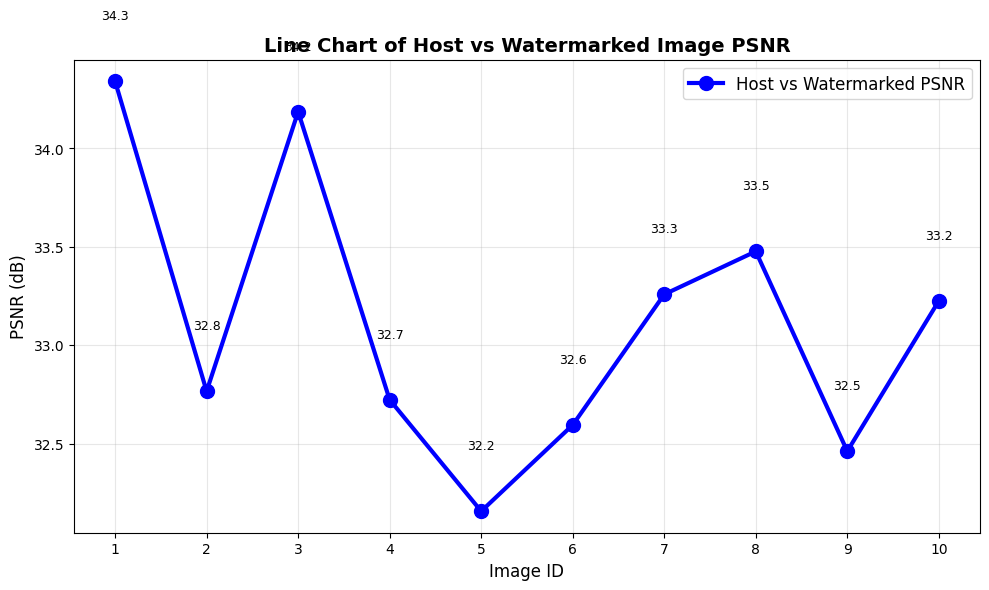

In [3]:
# ==========================================
# Host vs Watermarked PSNR Line Chart
# ==========================================
plt.figure(figsize=(10, 6))
x = range(1, len(all_results) + 1)
plt.plot(x, df['psnr_embed'], 'o-', linewidth=3, markersize=10, color='blue', label='Host vs Watermarked PSNR')
plt.title('Line Chart of Host vs Watermarked Image PSNR', fontsize=14, fontweight='bold')
plt.xlabel('Image ID', fontsize=12)
plt.ylabel('PSNR (dB)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(x)

# Add value labels on points
for i, psnr in enumerate(df['psnr_embed']):
    plt.text(i+1, psnr + 0.3, f'{psnr:.1f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(f"{OUTPUT_PATH}00_host_watermarked_psnr_line.png", dpi=300, bbox_inches='tight')
plt.show()

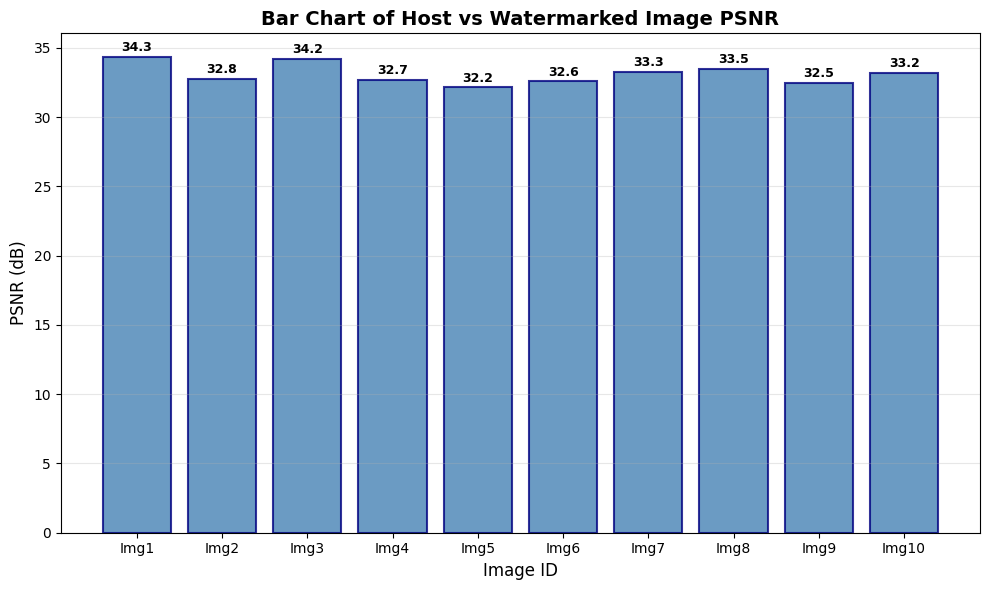

In [4]:
# ==========================================
# Host vs Watermarked PSNR Bar Chart
# ==========================================
plt.figure(figsize=(10, 6))
x_pos = np.arange(len(all_results))
bars = plt.bar(x_pos, df['psnr_embed'], alpha=0.8, color='steelblue', edgecolor='navy', linewidth=1.5)
plt.title('Bar Chart of Host vs Watermarked Image PSNR', fontsize=14, fontweight='bold')
plt.xlabel('Image ID', fontsize=12)
plt.ylabel('PSNR (dB)', fontsize=12)
plt.xticks(x_pos, [f'Img{i+1}' for i in range(len(all_results))])
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, psnr in zip(bars, df['psnr_embed']):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.2,
            f'{psnr:.1f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig(f"{OUTPUT_PATH}00_host_watermarked_psnr_bar.png", dpi=300, bbox_inches='tight')
plt.show()

# BER

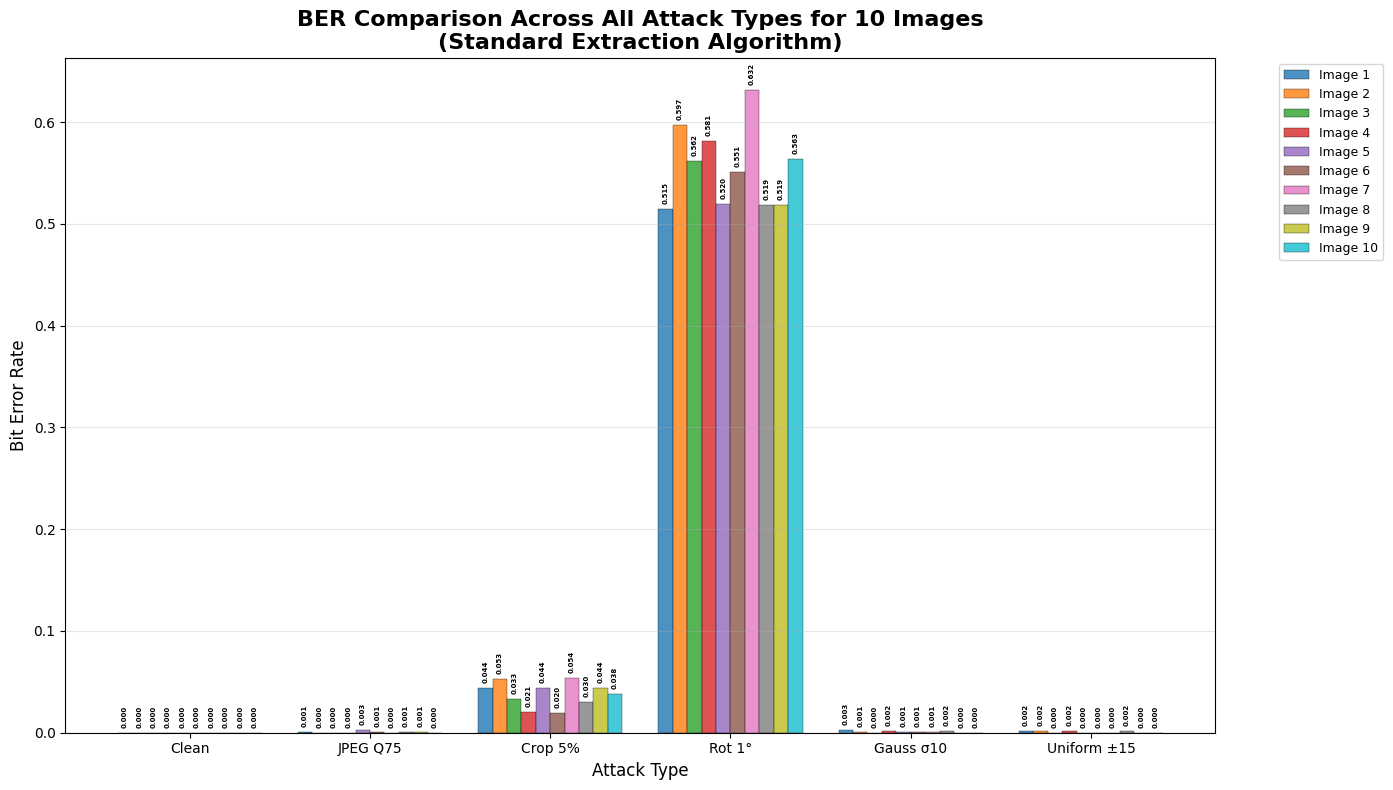


BER SUMMARY - STANDARD EXTRACTION ALGORITHM
Attack Type     Min BER    Max BER    Mean BER   Std BER   
-----------------------------------------------------------------
Clean           0.0000     0.0000     0.0000     0.0000    
JPEG Q75        0.0000     0.0029     0.0007     0.0009    
Crop 5%         0.0195     0.0537     0.0380     0.0120    
Rot 1°          0.5146     0.6318     0.5557     0.0394    
Gauss σ10       0.0000     0.0029     0.0011     0.0010    
Uniform ±15     0.0000     0.0020     0.0008     0.0010    


In [5]:
# ==========================================
# 3. Bar chart - BER for all attacks with all 10 images (Standard extraction algorithm only)
# ==========================================
plt.figure(figsize=(14, 8))

# Prepare data for all attacks across all images
attack_types = ['Clean', 'JPEG Q75', 'Crop 5%', 'Rot 1°', 'Gauss σ10', 'Uniform ±15']
attack_keys = ['clean', 'jpeg', 'crop', 'rot', 'gauss', 'uniform']

# Create color map for 10 images
image_colors = plt.cm.tab10(np.linspace(0, 1, len(all_results)))

num_images = len(all_results)
num_attacks = len(attack_types)
bar_width = 0.08
x_pos = np.arange(num_attacks)

# Create bars for each image
for img_idx in range(num_images):
    ber_values_per_image = []
    for attack_key in attack_keys:
        ber_values_per_image.append(df.iloc[img_idx][f'{attack_key}_ber_std'])
    
    # Position bars for this image
    img_x_pos = x_pos + (img_idx - num_images/2 + 0.5) * bar_width
    
    bars = plt.bar(img_x_pos, ber_values_per_image, bar_width, 
                   label=f'Image {img_idx+1}', alpha=0.8, 
                   color=image_colors[img_idx], edgecolor='black', linewidth=0.3)
    
    # Add value labels on ALL bars
    for bar, ber_val in zip(bars, ber_values_per_image):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{ber_val:.3f}', ha='center', va='bottom', fontsize=5, fontweight='bold',
                rotation=90)

plt.title('BER Comparison Across All Attack Types for 10 Images\n(Standard Extraction Algorithm)', 
          fontsize=16, fontweight='bold')
plt.ylabel('Bit Error Rate', fontsize=12)
plt.xlabel('Attack Type', fontsize=12)
plt.xticks(x_pos, attack_types)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9, ncol=1)
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(f"{OUTPUT_PATH}03_ber_all_attacks_all_images_std.png", dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\n" + "="*80)
print("BER SUMMARY - STANDARD EXTRACTION ALGORITHM")
print("="*80)
print(f"{'Attack Type':<15} {'Min BER':<10} {'Max BER':<10} {'Mean BER':<10} {'Std BER':<10}")
print("-" * 65)
for i, (attack_key, attack_name) in enumerate(zip(attack_keys, attack_types)):
    col_name = f'{attack_key}_ber_std'
    min_ber = df[col_name].min()
    max_ber = df[col_name].max()
    mean_ber = df[col_name].mean()
    std_ber = df[col_name].std()
    print(f"{attack_name:<15} {min_ber:<10.4f} {max_ber:<10.4f} {mean_ber:<10.4f} {std_ber:<10.4f}")

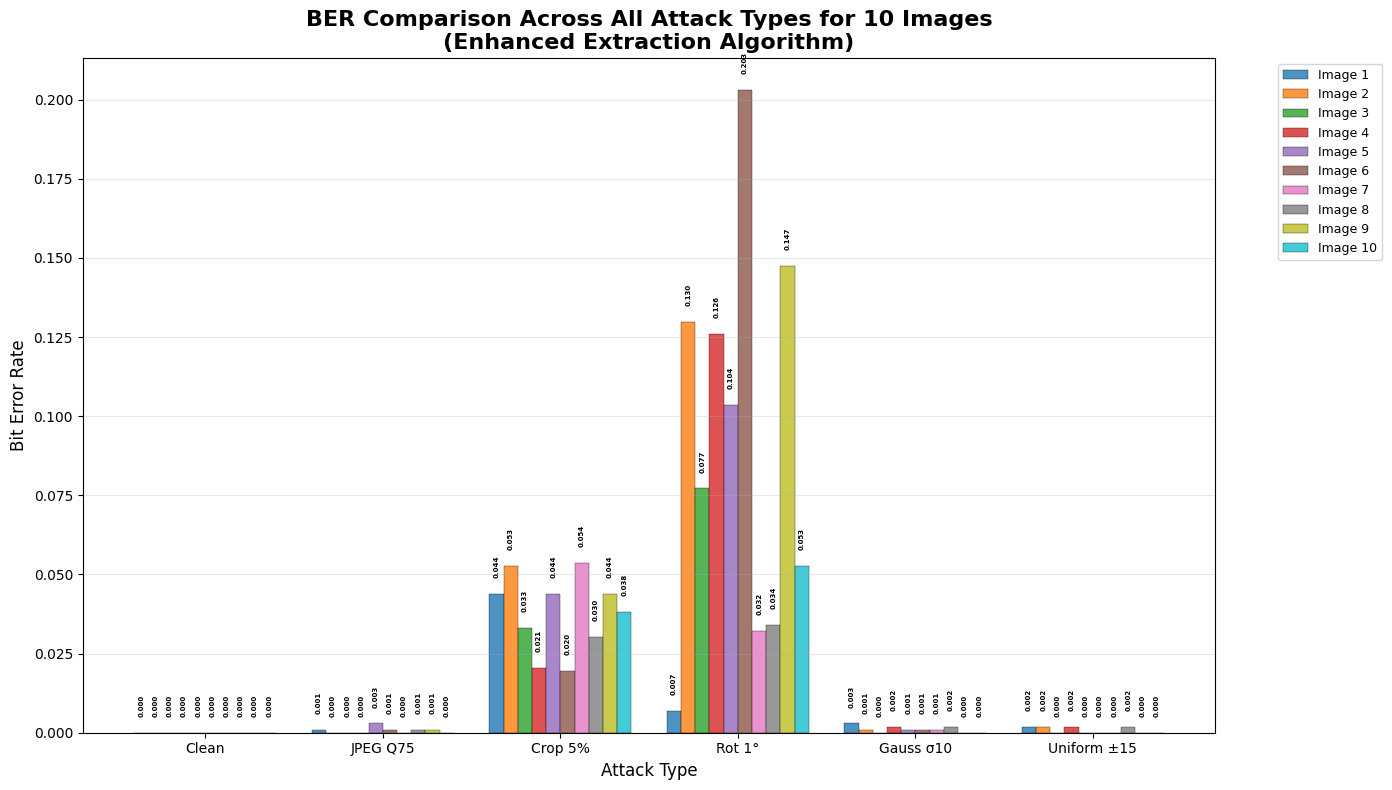


BER SUMMARY - ENHANCED EXTRACTION ALGORITHM
Attack Type     Min BER    Max BER    Mean BER   Std BER   
-----------------------------------------------------------------
Clean           0.0000     0.0000     0.0000     0.0000    
JPEG Q75        0.0000     0.0029     0.0007     0.0009    
Crop 5%         0.0195     0.0537     0.0380     0.0120    
Rot 1°          0.0068     0.2031     0.0913     0.0615    
Gauss σ10       0.0000     0.0029     0.0011     0.0010    
Uniform ±15     0.0000     0.0020     0.0008     0.0010    


In [6]:
# ==========================================
# 3. Bar chart - BER for all attacks with all 10 images (Enhanced extraction algorithm only)
# ==========================================
plt.figure(figsize=(14, 8))

# Prepare data for all attacks across all images
attack_types = ['Clean', 'JPEG Q75', 'Crop 5%', 'Rot 1°', 'Gauss σ10', 'Uniform ±15']
attack_keys = ['clean', 'jpeg', 'crop', 'rot', 'gauss', 'uniform']

# Create color map for 10 images
image_colors = plt.cm.tab10(np.linspace(0, 1, len(all_results)))

num_images = len(all_results)
num_attacks = len(attack_types)
bar_width = 0.08
x_pos = np.arange(num_attacks)

# Create bars for each image
for img_idx in range(num_images):
    ber_values_per_image = []
    for attack_key in attack_keys:
        ber_values_per_image.append(df.iloc[img_idx][f'{attack_key}_ber_enh'])
    
    # Position bars for this image
    img_x_pos = x_pos + (img_idx - num_images/2 + 0.5) * bar_width
    
    bars = plt.bar(img_x_pos, ber_values_per_image, bar_width, 
                   label=f'Image {img_idx+1}', alpha=0.8, 
                   color=image_colors[img_idx], edgecolor='black', linewidth=0.3)
    
    # Add value labels on bars
    for bar, ber_val in zip(bars, ber_values_per_image):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{ber_val:.3f}', ha='center', va='bottom', fontsize=5, fontweight='bold',
                rotation=90)

plt.title('BER Comparison Across All Attack Types for 10 Images\n(Enhanced Extraction Algorithm)', 
          fontsize=16, fontweight='bold')
plt.ylabel('Bit Error Rate', fontsize=12)
plt.xlabel('Attack Type', fontsize=12)
plt.xticks(x_pos, attack_types)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9, ncol=1)
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(f"{OUTPUT_PATH}03_ber_all_attacks_all_images_enh.png", dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\n" + "="*80)
print("BER SUMMARY - ENHANCED EXTRACTION ALGORITHM")
print("="*80)
print(f"{'Attack Type':<15} {'Min BER':<10} {'Max BER':<10} {'Mean BER':<10} {'Std BER':<10}")
print("-" * 65)
for i, (attack_key, attack_name) in enumerate(zip(attack_keys, attack_types)):
    col_name = f'{attack_key}_ber_enh'
    min_ber = df[col_name].min()
    max_ber = df[col_name].max()
    mean_ber = df[col_name].mean()
    std_ber = df[col_name].std()
    print(f"{attack_name:<15} {min_ber:<10.4f} {max_ber:<10.4f} {mean_ber:<10.4f} {std_ber:<10.4f}")

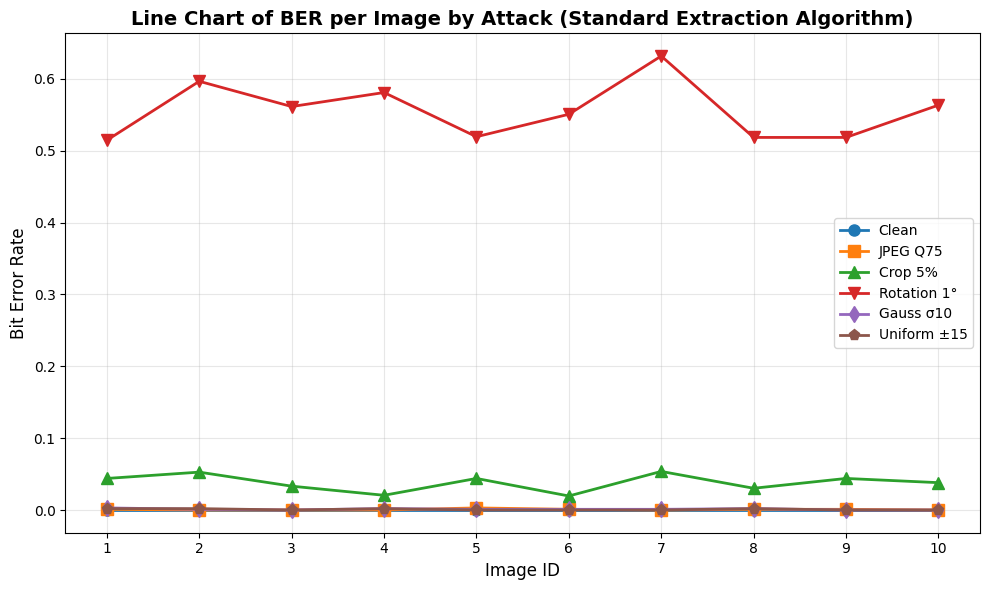

In [7]:
# ==========================================
# 4. Line chart - BER for each attack (Standard extraction algorithm)
# ==========================================
plt.figure(figsize=(10, 6))
x = range(1, len(all_results) + 1)

plt.plot(x, df['clean_ber_std'], 'o-', linewidth=2, markersize=8, label='Clean')
plt.plot(x, df['jpeg_ber_std'], 's-', linewidth=2, markersize=8, label='JPEG Q75')
plt.plot(x, df['crop_ber_std'], '^-', linewidth=2, markersize=8, label='Crop 5%')
plt.plot(x, df['rot_ber_std'], 'v-', linewidth=2, markersize=8, label='Rotation 1°')
plt.plot(x, df['gauss_ber_std'], 'd-', linewidth=2, markersize=8, label='Gauss σ10')
plt.plot(x, df['uniform_ber_std'], 'p-', linewidth=2, markersize=8, label='Uniform ±15')

plt.title('Line Chart of BER per Image by Attack (Standard Extraction Algorithm)', fontsize=14, fontweight='bold')
plt.xlabel('Image ID', fontsize=12)
plt.ylabel('Bit Error Rate', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(x)
plt.tight_layout()
plt.savefig(f"{OUTPUT_PATH}04_ber_line_chart.png", dpi=300, bbox_inches='tight')
plt.show()

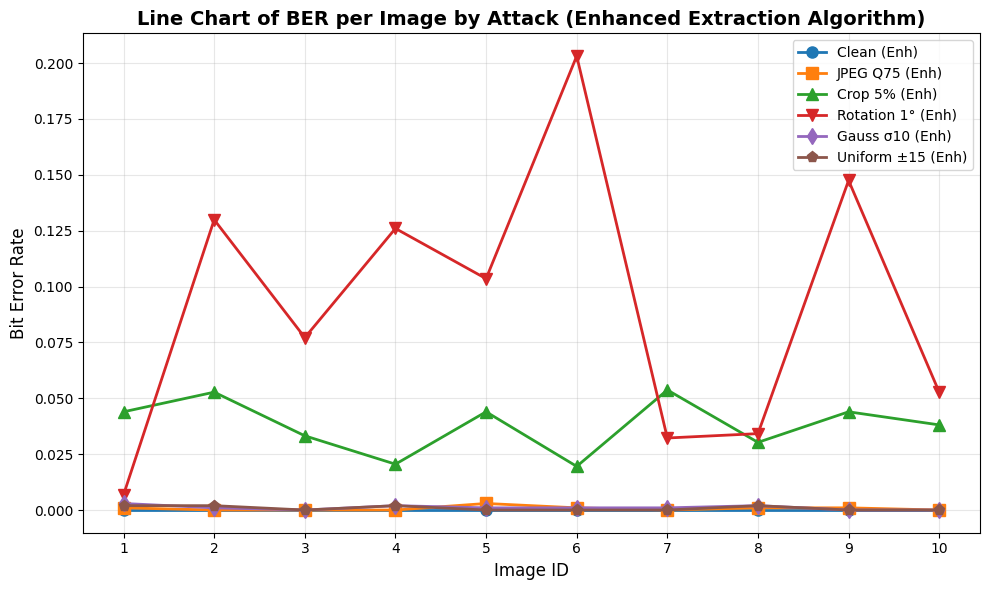

In [8]:
# ==========================================
# 4. Line chart - BER for each attack (Enhanced extraction algorithm)
# ==========================================
plt.figure(figsize=(10, 6))
x = range(1, len(all_results) + 1)

plt.plot(x, df['clean_ber_enh'], 'o-', linewidth=2, markersize=8, label='Clean (Enh)')
plt.plot(x, df['jpeg_ber_enh'], 's-', linewidth=2, markersize=8, label='JPEG Q75 (Enh)')
plt.plot(x, df['crop_ber_enh'], '^-', linewidth=2, markersize=8, label='Crop 5% (Enh)')
plt.plot(x, df['rot_ber_enh'], 'v-', linewidth=2, markersize=8, label='Rotation 1° (Enh)')
plt.plot(x, df['gauss_ber_enh'], 'd-', linewidth=2, markersize=8, label='Gauss σ10 (Enh)')
plt.plot(x, df['uniform_ber_enh'], 'p-', linewidth=2, markersize=8, label='Uniform ±15 (Enh)')

plt.title('Line Chart of BER per Image by Attack (Enhanced Extraction Algorithm)', fontsize=14, fontweight='bold')
plt.xlabel('Image ID', fontsize=12)
plt.ylabel('Bit Error Rate', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(x)
plt.tight_layout()
plt.savefig(f"{OUTPUT_PATH}04_ber_line_chart.png", dpi=300, bbox_inches='tight')
plt.show()

# NCC

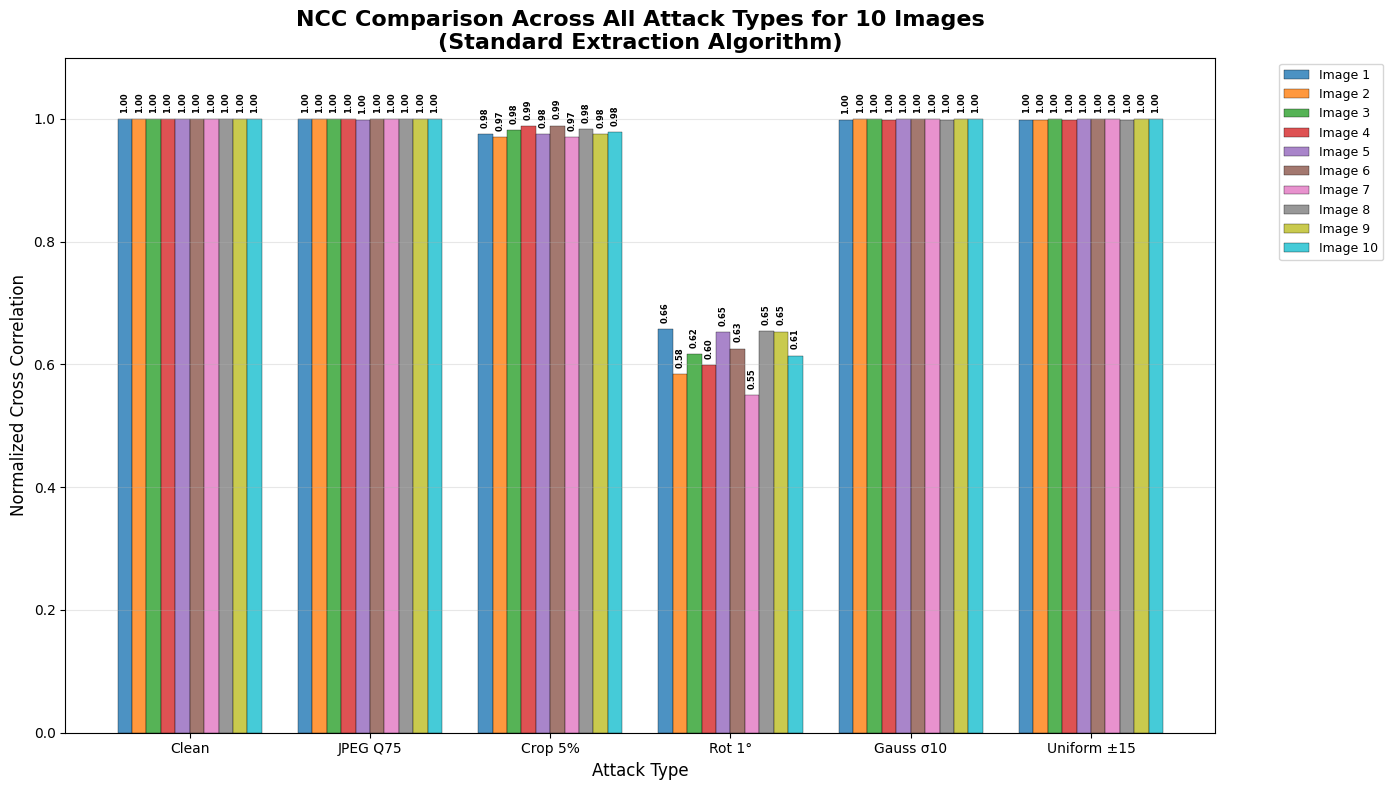


NCC SUMMARY - STANDARD EXTRACTION ALGORITHM
Attack Type     Min NCC    Max NCC    Mean NCC   Std NCC   
-----------------------------------------------------------------
Clean           1.0000     1.0000     1.0000     0.0000    
JPEG Q75        0.9984     1.0000     0.9996     0.0005    
Crop 5%         0.9699     0.9892     0.9788     0.0068    
Rot 1°          0.5496     0.6576     0.6206     0.0358    
Gauss σ10       0.9984     1.0000     0.9994     0.0005    
Uniform ±15     0.9989     1.0000     0.9996     0.0006    


In [9]:
# ==========================================
# 3. Bar chart - NCC for all attacks with all 10 images (Standard extraction algorithm only)
# ==========================================
plt.figure(figsize=(14, 8))

# Prepare data for all attacks across all images
attack_types = ['Clean', 'JPEG Q75', 'Crop 5%', 'Rot 1°', 'Gauss σ10', 'Uniform ±15']
attack_keys = ['clean', 'jpeg', 'crop', 'rot', 'gauss', 'uniform']

# Create color map for 10 images
image_colors = plt.cm.tab10(np.linspace(0, 1, len(all_results)))

num_images = len(all_results)
num_attacks = len(attack_types)
bar_width = 0.08
x_pos = np.arange(num_attacks)

# Create bars for each image
for img_idx in range(num_images):
    ncc_values_per_image = []
    for attack_key in attack_keys:
        ncc_values_per_image.append(df.iloc[img_idx][f'{attack_key}_ncc_std'])
    
    # Position bars for this image
    img_x_pos = x_pos + (img_idx - num_images/2 + 0.5) * bar_width
    
    bars = plt.bar(img_x_pos, ncc_values_per_image, bar_width, 
                   label=f'Image {img_idx+1}', alpha=0.8, 
                   color=image_colors[img_idx], edgecolor='black', linewidth=0.3)
    
    # Add value labels on bars for low NCC values
    for bar, ncc_val in zip(bars, ncc_values_per_image):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{ncc_val:.2f}', ha='center', va='bottom', fontsize=6, fontweight='bold',
                rotation=90)

plt.title('NCC Comparison Across All Attack Types for 10 Images\n(Standard Extraction Algorithm)', 
          fontsize=16, fontweight='bold')
plt.ylabel('Normalized Cross Correlation', fontsize=12)
plt.xlabel('Attack Type', fontsize=12)
plt.xticks(x_pos, attack_types)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9, ncol=1)
plt.grid(True, alpha=0.3, axis='y')
plt.ylim(0, 1.1)  # Set y-axis limit for NCC values

plt.tight_layout()
plt.savefig(f"{OUTPUT_PATH}03_ncc_all_attacks_all_images_std.png", dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\n" + "="*80)
print("NCC SUMMARY - STANDARD EXTRACTION ALGORITHM")
print("="*80)
print(f"{'Attack Type':<15} {'Min NCC':<10} {'Max NCC':<10} {'Mean NCC':<10} {'Std NCC':<10}")
print("-" * 65)
for i, (attack_key, attack_name) in enumerate(zip(attack_keys, attack_types)):
    col_name = f'{attack_key}_ncc_std'
    min_ncc = df[col_name].min()
    max_ncc = df[col_name].max()
    mean_ncc = df[col_name].mean()
    std_ncc = df[col_name].std()
    print(f"{attack_name:<15} {min_ncc:<10.4f} {max_ncc:<10.4f} {mean_ncc:<10.4f} {std_ncc:<10.4f}")

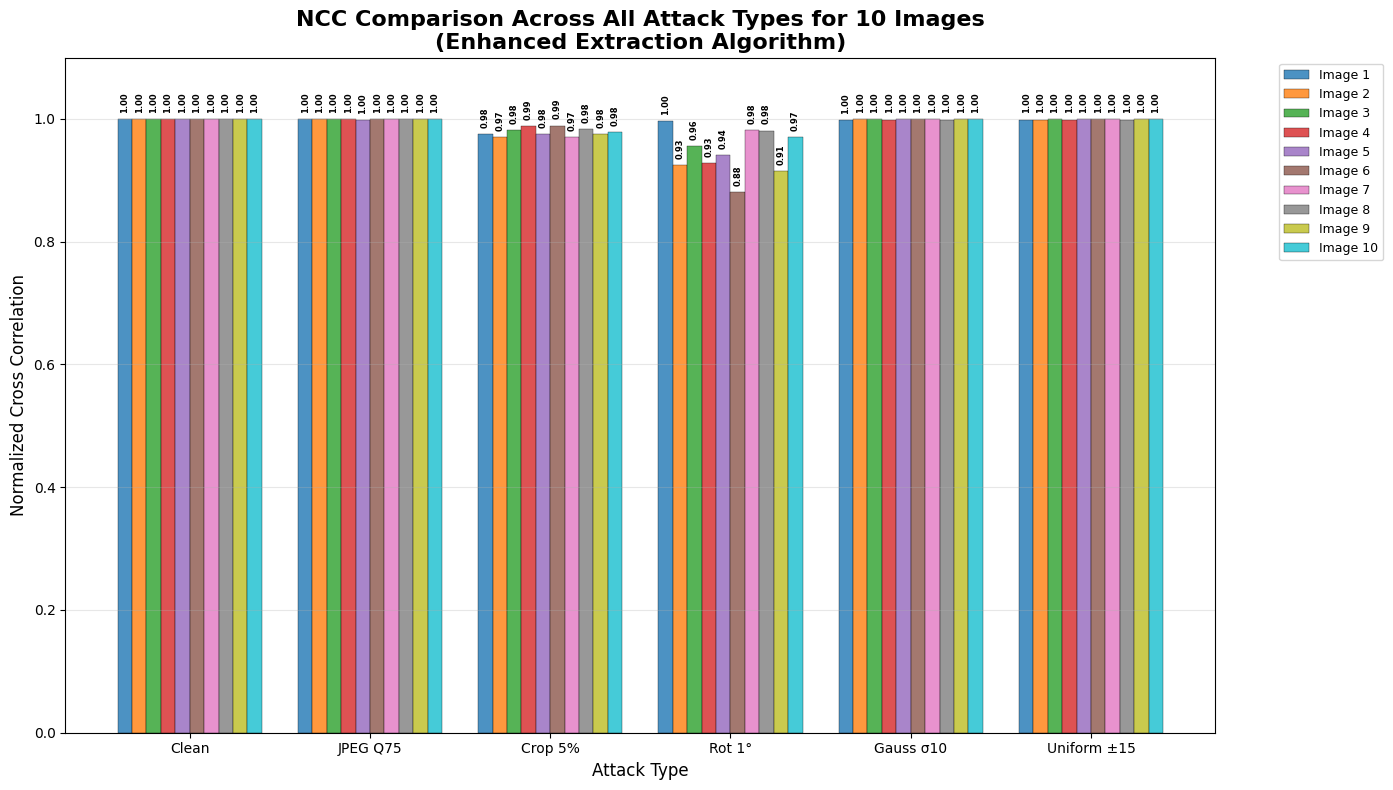


NCC SUMMARY - ENHANCED EXTRACTION ALGORITHM
Attack Type     Min NCC    Max NCC    Mean NCC   Std NCC   
-----------------------------------------------------------------
Clean           1.0000     1.0000     1.0000     0.0000    
JPEG Q75        0.9984     1.0000     0.9996     0.0005    
Crop 5%         0.9699     0.9892     0.9788     0.0068    
Rot 1°          0.8807     0.9962     0.9476     0.0361    
Gauss σ10       0.9984     1.0000     0.9994     0.0005    
Uniform ±15     0.9989     1.0000     0.9996     0.0006    


In [10]:
# ==========================================
# 3. Bar chart - NCC for all attacks with all 10 images (Enhanced extraction algorithm only)
# ==========================================
plt.figure(figsize=(14, 8))

# Prepare data for all attacks across all images
attack_types = ['Clean', 'JPEG Q75', 'Crop 5%', 'Rot 1°', 'Gauss σ10', 'Uniform ±15']
attack_keys = ['clean', 'jpeg', 'crop', 'rot', 'gauss', 'uniform']

# Create color map for 10 images
image_colors = plt.cm.tab10(np.linspace(0, 1, len(all_results)))

num_images = len(all_results)
num_attacks = len(attack_types)
bar_width = 0.08
x_pos = np.arange(num_attacks)

# Create bars for each image
for img_idx in range(num_images):
    ncc_values_per_image = []
    for attack_key in attack_keys:
        ncc_values_per_image.append(df.iloc[img_idx][f'{attack_key}_ncc_enh'])
    
    # Position bars for this image
    img_x_pos = x_pos + (img_idx - num_images/2 + 0.5) * bar_width
    
    bars = plt.bar(img_x_pos, ncc_values_per_image, bar_width, 
                   label=f'Image {img_idx+1}', alpha=0.8, 
                   color=image_colors[img_idx], edgecolor='black', linewidth=0.3)
    
    # Add value labels on bars for low NCC values
    for bar, ncc_val in zip(bars, ncc_values_per_image):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{ncc_val:.2f}', ha='center', va='bottom', fontsize=6, fontweight='bold',
                rotation=90)

plt.title('NCC Comparison Across All Attack Types for 10 Images\n(Enhanced Extraction Algorithm)', 
          fontsize=16, fontweight='bold')
plt.ylabel('Normalized Cross Correlation', fontsize=12)
plt.xlabel('Attack Type', fontsize=12)
plt.xticks(x_pos, attack_types)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9, ncol=1)
plt.grid(True, alpha=0.3, axis='y')
plt.ylim(0, 1.1)  # Set y-axis limit for NCC values

plt.tight_layout()
plt.savefig(f"{OUTPUT_PATH}03_ncc_all_attacks_all_images_enh.png", dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\n" + "="*80)
print("NCC SUMMARY - ENHANCED EXTRACTION ALGORITHM")
print("="*80)
print(f"{'Attack Type':<15} {'Min NCC':<10} {'Max NCC':<10} {'Mean NCC':<10} {'Std NCC':<10}")
print("-" * 65)
for i, (attack_key, attack_name) in enumerate(zip(attack_keys, attack_types)):
    col_name = f'{attack_key}_ncc_enh'
    min_ncc = df[col_name].min()
    max_ncc = df[col_name].max()
    mean_ncc = df[col_name].mean()
    std_ncc = df[col_name].std()
    print(f"{attack_name:<15} {min_ncc:<10.4f} {max_ncc:<10.4f} {mean_ncc:<10.4f} {std_ncc:<10.4f}")

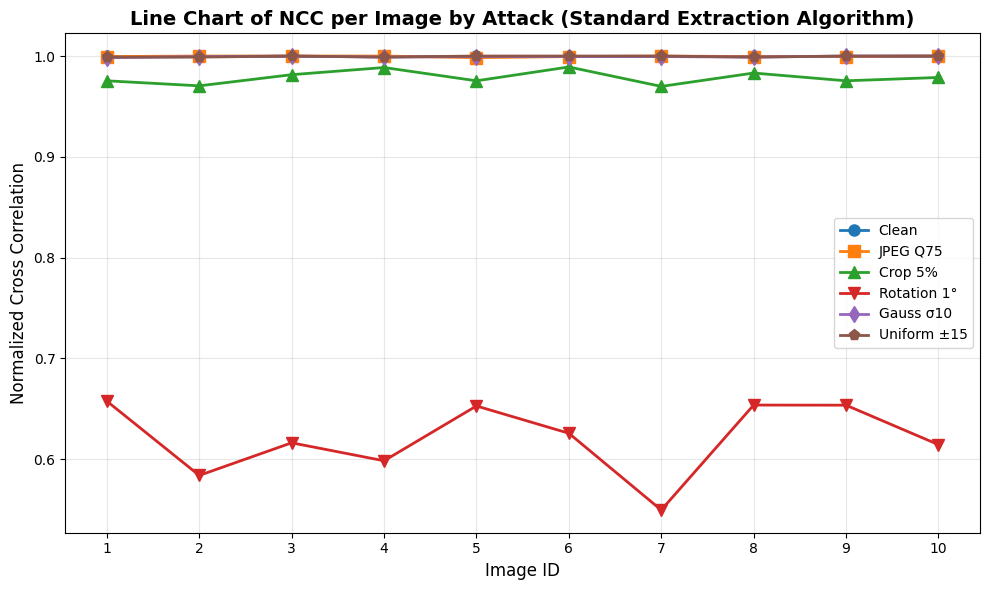

In [11]:
# ==========================================
# Line chart - NCC for each attack (standard extraction algorithm)
# ==========================================
plt.figure(figsize=(10, 6))

plt.plot(x, df['clean_ncc_std'], 'o-', linewidth=2, markersize=8, label='Clean')
plt.plot(x, df['jpeg_ncc_std'], 's-', linewidth=2, markersize=8, label='JPEG Q75')
plt.plot(x, df['crop_ncc_std'], '^-', linewidth=2, markersize=8, label='Crop 5%')
plt.plot(x, df['rot_ncc_std'], 'v-', linewidth=2, markersize=8, label='Rotation 1°')
plt.plot(x, df['gauss_ncc_std'], 'd-', linewidth=2, markersize=8, label='Gauss σ10')
plt.plot(x, df['uniform_ncc_std'], 'p-', linewidth=2, markersize=8, label='Uniform ±15')

plt.title('Line Chart of NCC per Image by Attack (Standard Extraction Algorithm)', fontsize=14, fontweight='bold')
plt.xlabel('Image ID', fontsize=12)
plt.ylabel('Normalized Cross Correlation', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(x)
plt.tight_layout()
plt.savefig(f"{OUTPUT_PATH}06_ncc_line_chart.png", dpi=300, bbox_inches='tight')
plt.show()

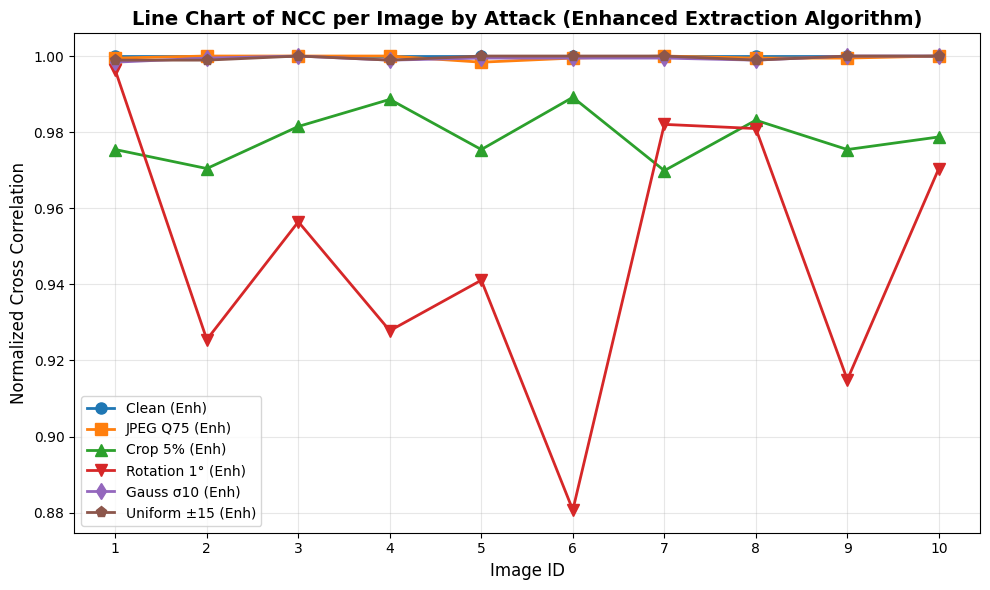

In [12]:
# ==========================================
# Line chart - NCC for each attack (enhanced extraction algorithm)
# ==========================================
plt.figure(figsize=(10, 6))
x = range(1, len(all_results) + 1)

plt.plot(x, df['clean_ncc_enh'], 'o-', linewidth=2, markersize=8, label='Clean (Enh)')
plt.plot(x, df['jpeg_ncc_enh'], 's-', linewidth=2, markersize=8, label='JPEG Q75 (Enh)')
plt.plot(x, df['crop_ncc_enh'], '^-', linewidth=2, markersize=8, label='Crop 5% (Enh)')
plt.plot(x, df['rot_ncc_enh'], 'v-', linewidth=2, markersize=8, label='Rotation 1° (Enh)')
plt.plot(x, df['gauss_ncc_enh'], 'd-', linewidth=2, markersize=8, label='Gauss σ10 (Enh)')
plt.plot(x, df['uniform_ncc_enh'], 'p-', linewidth=2, markersize=8, label='Uniform ±15 (Enh)')

plt.title('Line Chart of NCC per Image by Attack (Enhanced Extraction Algorithm)', fontsize=14, fontweight='bold')
plt.xlabel('Image ID', fontsize=12)
plt.ylabel('Normalized Cross Correlation', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(x)
plt.tight_layout()
plt.savefig(f"{OUTPUT_PATH}06_ncc_line_chart.png", dpi=300, bbox_inches='tight')
plt.show()

# Additional

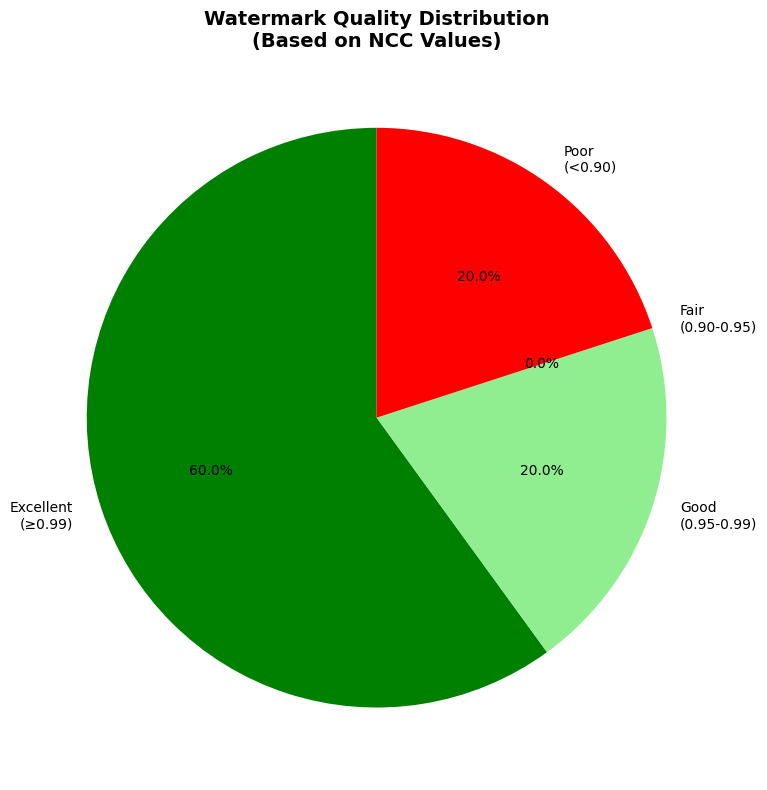

In [13]:
# ==========================================
# Pie chart - Watermark quality distribution
# ==========================================
plt.figure(figsize=(8, 8))
# Categorize NCC values across all attacks (excluding clean)
all_ncc_values = []
for attack in ['jpeg_ncc_std', 'crop_ncc_std', 'rot_ncc_std', 'gauss_ncc_std', 'uniform_ncc_std']:
    all_ncc_values.extend(df[attack].tolist())

excellent = sum(1 for ncc in all_ncc_values if ncc >= 0.99)
good = sum(1 for ncc in all_ncc_values if 0.95 <= ncc < 0.99)
fair = sum(1 for ncc in all_ncc_values if 0.90 <= ncc < 0.95)
poor = sum(1 for ncc in all_ncc_values if ncc < 0.90)

quality_data = [excellent, good, fair, poor]
quality_labels = ['Excellent\n(≥0.99)', 'Good\n(0.95-0.99)', 'Fair\n(0.90-0.95)', 'Poor\n(<0.90)']
quality_colors = ['green', 'lightgreen', 'yellow', 'red']

wedges, texts, autotexts = plt.pie(quality_data, labels=quality_labels, autopct='%1.1f%%',
                                    colors=quality_colors, startangle=90)
plt.title('Watermark Quality Distribution\n(Based on NCC Values)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f"{OUTPUT_PATH}08_watermark_quality_pie.png", dpi=300, bbox_inches='tight')
plt.show()

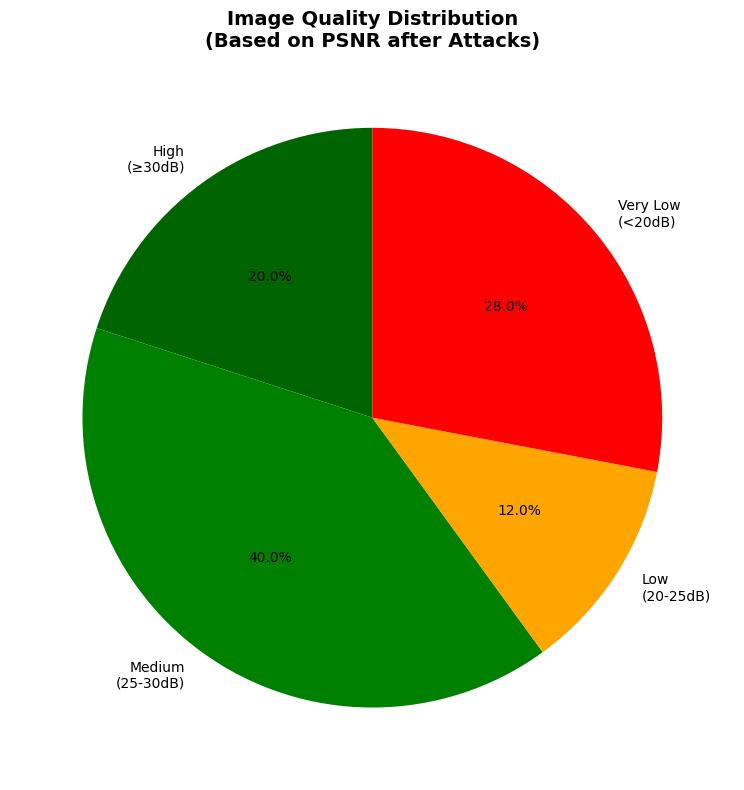

In [14]:
# ==========================================
# Pie chart - PSNR quality distribution
# ==========================================
plt.figure(figsize=(8, 8))
# Categorize PSNR values for attacked images
all_psnr_values = []
for attack in ['jpeg_psnr', 'crop_psnr', 'rot_psnr', 'gauss_psnr', 'uniform_psnr']:
    all_psnr_values.extend(df[attack].tolist())

high_quality = sum(1 for psnr in all_psnr_values if psnr >= 30)
medium_quality = sum(1 for psnr in all_psnr_values if 25 <= psnr < 30)
low_quality = sum(1 for psnr in all_psnr_values if 20 <= psnr < 25)
very_low_quality = sum(1 for psnr in all_psnr_values if psnr < 20)

psnr_data = [high_quality, medium_quality, low_quality, very_low_quality]
psnr_labels = ['High\n(≥30dB)', 'Medium\n(25-30dB)', 'Low\n(20-25dB)', 'Very Low\n(<20dB)']
psnr_colors = ['darkgreen', 'green', 'orange', 'red']

wedges, texts, autotexts = plt.pie(psnr_data, labels=psnr_labels, autopct='%1.1f%%',
                                    colors=psnr_colors, startangle=90)
plt.title('Image Quality Distribution\n(Based on PSNR after Attacks)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f"{OUTPUT_PATH}09_image_quality_pie.png", dpi=300, bbox_inches='tight')
plt.show()

C:\Users\Vin Sen\AppData\Local\Temp\ipykernel_38708\1688528863.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = plt.boxplot(ber_data, labels=attack_names, patch_artist=True)


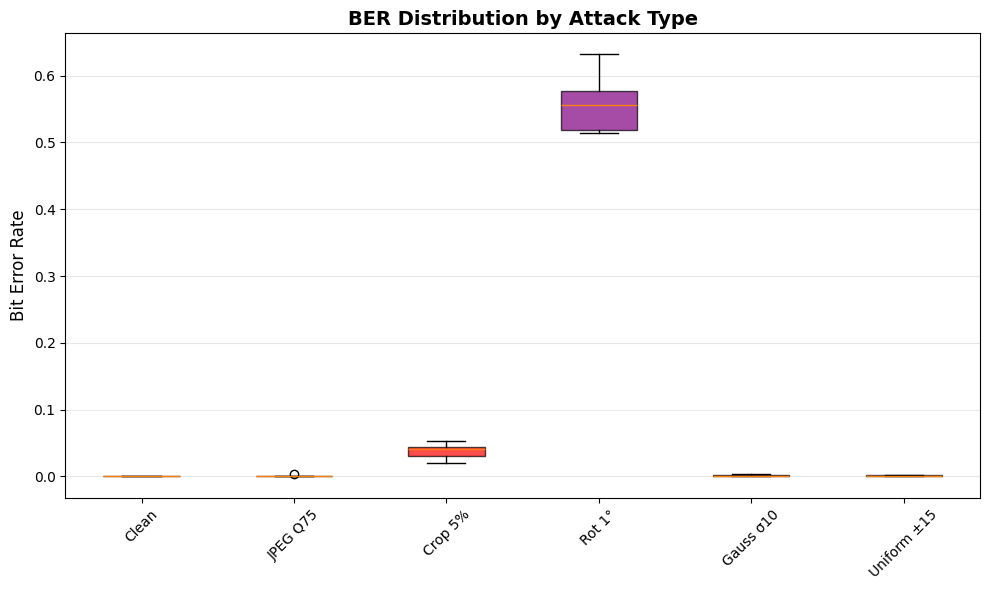

In [16]:
# ==========================================
# Box plot - BER distribution
# ==========================================
plt.figure(figsize=(10, 6))
ber_data = [df['clean_ber_std'], df['jpeg_ber_std'], df['crop_ber_std'], 
            df['rot_ber_std'], df['gauss_ber_std'], df['uniform_ber_std']]

attack_names = ['Clean', 'JPEG Q75', 'Crop 5%', 'Rot 1°', 'Gauss σ10', 'Uniform ±15']
colors = ['green', 'orange', 'red', 'purple', 'brown', 'pink']
box_plot = plt.boxplot(ber_data, labels=attack_names, patch_artist=True)
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

plt.title('BER Distribution by Attack Type', fontsize=14, fontweight='bold')
plt.ylabel('Bit Error Rate', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig(f"{OUTPUT_PATH}10_ber_boxplot.png", dpi=300, bbox_inches='tight')
plt.show()

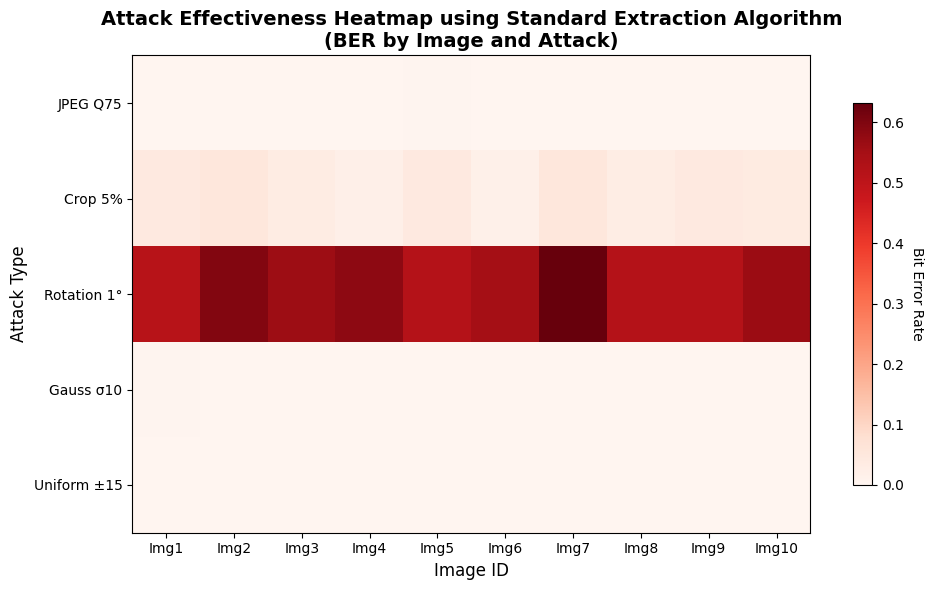

In [17]:
# ==========================================
# Heatmap - Attack effectiveness
# ==========================================
plt.figure(figsize=(10, 6))
heatmap_data = np.array([
    df['jpeg_ber_std'].values,
    df['crop_ber_std'].values,
    df['rot_ber_std'].values,
    df['gauss_ber_std'].values,
    df['uniform_ber_std'].values
])

im = plt.imshow(heatmap_data, cmap='Reds', aspect='auto')
plt.title('Attack Effectiveness Heatmap using Standard Extraction Algorithm\n(BER by Image and Attack)', fontsize=14, fontweight='bold')
plt.ylabel('Attack Type', fontsize=12)
plt.xlabel('Image ID', fontsize=12)
plt.yticks(range(5), ['JPEG Q75', 'Crop 5%', 'Rotation 1°', 'Gauss σ10', 'Uniform ±15'])
plt.xticks(range(len(all_results)), [f'Img{i+1}' for i in range(len(all_results))])

# Add colorbar
cbar = plt.colorbar(im, shrink=0.8)
cbar.set_label('Bit Error Rate', rotation=270, labelpad=15)

plt.tight_layout()
plt.savefig(f"{OUTPUT_PATH}11_attack_effectiveness_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()

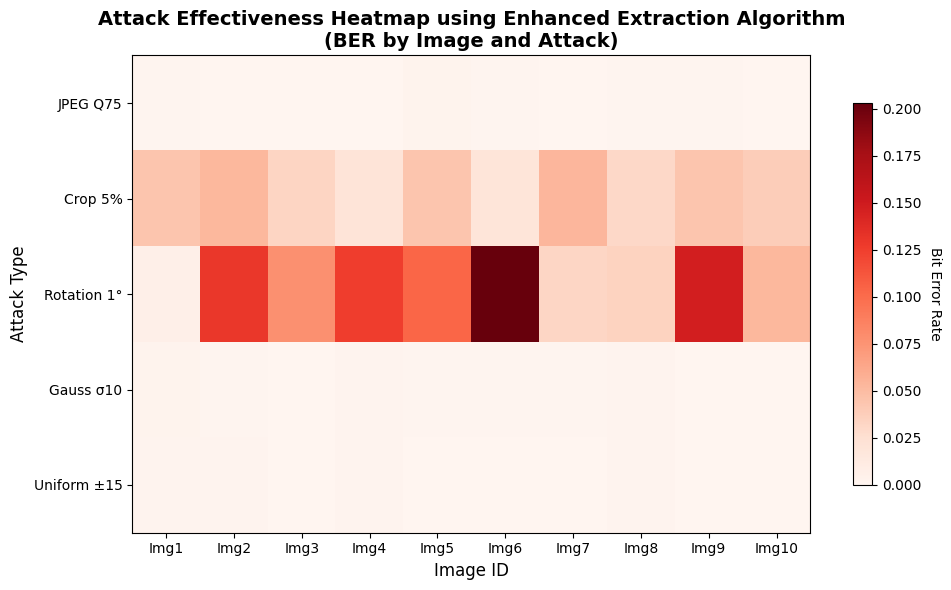

In [18]:
# ==========================================
# Heatmap - Attack effectiveness (enhanced extraction algorithm)
# ==========================================
plt.figure(figsize=(10, 6))
heatmap_data = np.array([
    df['jpeg_ber_enh'].values,
    df['crop_ber_enh'].values,
    df['rot_ber_enh'].values,
    df['gauss_ber_enh'].values,
    df['uniform_ber_enh'].values
])

im = plt.imshow(heatmap_data, cmap='Reds', aspect='auto')
plt.title('Attack Effectiveness Heatmap using Enhanced Extraction Algorithm\n(BER by Image and Attack)', fontsize=14, fontweight='bold')
plt.ylabel('Attack Type', fontsize=12)
plt.xlabel('Image ID', fontsize=12)
plt.yticks(range(5), ['JPEG Q75', 'Crop 5%', 'Rotation 1°', 'Gauss σ10', 'Uniform ±15'])
plt.xticks(range(len(all_results)), [f'Img{i+1}' for i in range(len(all_results))])

# Add colorbar
cbar = plt.colorbar(im, shrink=0.8)
cbar.set_label('Bit Error Rate', rotation=270, labelpad=15)

plt.tight_layout()
plt.savefig(f"{OUTPUT_PATH}11_attack_effectiveness_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()